# Signate開始時のお約束

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [3]:
!pip install signate

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=01dbcc7f20d0e0d10d2f4b0b8772d53eb7528e0b69efb7ffb62a2ddf83da2c79
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [4]:
!signate files --competition-id=1523

  fileId  name               title                     size  updated_at
--------  -----------------  ----------------------  ------  -------------------
    3939  train.csv          学習用データ            494008  2024-08-01 12:00:28
    3940  test.csv           評価用データ            488363  2024-08-01 12:00:38
    3944  sample_submit.csv  応募用サンプルファイル   86893  2024-08-01 12:00:49
    4057  tutorial.ipynb     チュートリアルコード    323126  2024-08-01 12:01:00


In [5]:
!signate download --competition-id=1523

sample_submit.csv

tutorial.ipynb

test.csv

train.csv


Download completed.


In [6]:
!pip install kanjize

In [7]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 13.4 MB/s eta 0:00:00


In [8]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# データフレーム読み込み
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

In [9]:
# データ結合(番号を振り直す)
all_df = pd.concat([train_df,test_df],axis=0,ignore_index=True)
max_row = len(all_df)

In [10]:
# 元のカラム順
colorigin = all_df.columns

<ipython-input-11-8331b9fb236d>:45: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())


<Axes: >

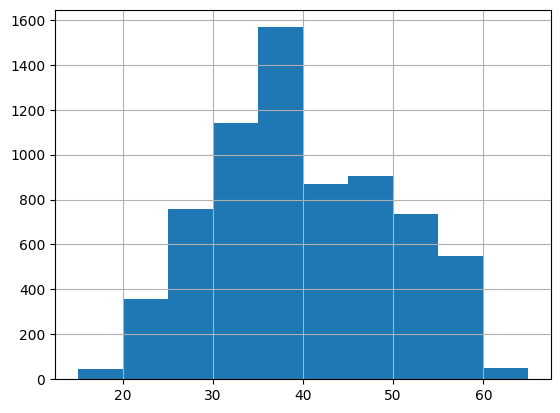

In [11]:
###############
# "Age"の処理 #
###############
import unicodedata # 全角を半角に変換
from kanjize import kanji2number # 漢字を数値に変換
import re

# 漢字の判定用
p = re.compile('[一二三四五六七八九十]+')

# nanを-1歳で補完
all_df["Age"] = all_df["Age"].fillna("-1歳")

# Ageの処理
for i in range(max_row):

  # 末尾文字の取得
  tail = all_df.loc[i,"Age"][-1:]

  # 先頭文字が漢字の場合
  if(p.search(all_df.loc[i,"Age"][0])!=None):
    tmp = all_df.loc[i,"Age"][:-1]
    all_df.loc[i,"Age"] = kanji2number(tmp)
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 末尾文字が歳、才、際の場合
  elif((tail=="歳")or(tail=="才")or(tail=="際")):
    all_df.loc[i,"Age"] = all_df.loc[i,"Age"][:-1]
    # 全角を半角に直す
    all_df.loc[i,"Age"] = unicodedata.normalize("NFKC", all_df.loc[i,"Age"])
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 代の場合
  elif(tail == "代"):
    tmp = all_df.loc[i,"Age"][:-1]

    # 「代」は○5歳に変換する
    tmp = int(tmp)
    # 10歳で分けて5足す
    tmp = tmp//10 * 10
    all_df.loc[i,"Age"] = tmp + 5
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

# 「-1」はそれ以外の中央値を代入
all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())

# int型にキャストする
all_df["Age"] = all_df["Age"].astype(int)

# ヒストグラムを描く
all_df["Age"].hist()

In [12]:
#########################
# "TypeofContact"の処理 #
#########################
# 欠損は最頻値で補完する
all_df["TypeofContact"] = all_df["TypeofContact"].fillna("Self Enquiry")

# one-hot化して追加する
all_df.loc[all_df["TypeofContact"]=="Self Enquiry","TypeofContact"] = 0
all_df.loc[all_df["TypeofContact"]=="Company Invited","TypeofContact"] = 1

# 列名を変更
all_df = all_df.rename(columns={"TypeofContact":"CompanyInvited"})

print(all_df["CompanyInvited"].value_counts())

CompanyInvited
0    4462
1    2516
Name: count, dtype: int64


In [13]:
#########################
# "CityTier"の処理 #
#########################
print(all_df["CityTier"].value_counts())

CityTier
2    3160
1    2991
3     827
Name: count, dtype: int64


In [14]:
#########################
# "DurationOfPitch"の処理 #
#########################
# nanを-1分で補完
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].fillna("-1分")

# 秒を分に変換 #
for i in range(max_row):

  tail = str(all_df.loc[i,"DurationOfPitch"])[-1:]

  if(tail == "秒"):
    tmp = all_df.loc[i,"DurationOfPitch"][:-1]
    all_df.loc[i,"DurationOfPitch"] = float(tmp) / 60.0
  elif(tail == "分"):
    all_df.loc[i,"DurationOfPitch"] = all_df.loc[i,"DurationOfPitch"][:-1]

all_df["DurationOfPitch"] = all_df["DurationOfPitch"].astype("float64")

# 「-1」はそれ以外の中央値を代入
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].replace(-1,all_df.loc[all_df["DurationOfPitch"]>0,"DurationOfPitch"].median())

# 重要でないため、10分刻みのカテゴリにする
all_df["DurationOfPitch"] = (all_df["DurationOfPitch"].values // 10).astype(int)

# 分布を確認する
print(all_df["DurationOfPitch"].value_counts())

DurationOfPitch
1    3824
0    1984
2     709
3     461
Name: count, dtype: int64


In [15]:
####################
# "Occupation"の処理 #
####################
# 特徴量を追加する
all_df["SmallBusiness"] = 0
all_df["Salaried"] = 0
all_df["LargeBusiness"] = 0

# one-hot化して追加する
all_df.loc[all_df["Occupation"]=="Small Business","SmallBusiness"] = 1
all_df.loc[all_df["Occupation"]=="Salaried","Salaried"] = 1
all_df.loc[all_df["Occupation"]=="Large Business","LargeBusiness"] = 1

# 元のカラムを削除する
all_df = all_df.drop("Occupation", axis=1)

print(all_df["SmallBusiness"].value_counts())
print(all_df["Salaried"].value_counts())
print(all_df["LargeBusiness"].value_counts())

SmallBusiness
0    3522
1    3456
Name: count, dtype: int64
Salaried
0    4177
1    2801
Name: count, dtype: int64
LargeBusiness
0    6257
1     721
Name: count, dtype: int64


In [16]:
##################
# "Genger"の処理 #
##################
# 先頭文字がMかmならMaleになる
for i in range(max_row):

  # 先頭文字の取得(半角)
  head = unicodedata.normalize("NFKC", all_df.loc[i,"Gender"][:1])
  if(head == "m"):
    all_df.loc[i,"Gender"] = "Male"
  else:
    all_df.loc[i,"Gender"] = "Female"

# one-hot化して追加する
all_df.loc[all_df["Gender"]=="Male","Gender"] = 1
all_df.loc[all_df["Gender"]=="Female","Gender"] = 0

# 列名を変更する
all_df = all_df.rename(columns={"Gender":"Male"})

print(all_df["Male"].value_counts())

Male
0    5946
1    1032
Name: count, dtype: int64


In [17]:
##################################
# "NumberOfPersonVisiting"の処理 #
##################################
print(all_df["NumberOfPersonVisiting"].value_counts())

NumberOfPersonVisiting
2.0    3163
3.0    2773
1.0     686
4.0     356
Name: count, dtype: int64


In [18]:
##################################
# "NumberOfFollowups"の処理 #
##################################

# 欠損を-1で埋めてから中央値を取る
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].fillna(-1)
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].replace(-1,all_df.loc[all_df["NumberOfFollowups"]>0,"NumberOfFollowups"].median())

# 100回以上は記録違いとして100で割る
all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] = all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] / 100

# 分布の確認
print(all_df["NumberOfFollowups"].value_counts())

NumberOfFollowups
4.0    2834
3.0    2561
5.0    1122
2.0     213
1.0     178
6.0      70
Name: count, dtype: int64


In [19]:
##########################
# "ProductPitched"の処理 #
##########################
# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdib"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

# Basic, Standard, Deluxe, Super Deluxe, kingに分ける
prefix = 0
others = []
# すべて小文字に変換し判定
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"ProductPitched"][:2].lower())).lower()

  if(prefix == "ba"):
    all_df.loc[i,"ProductPitched"] = "Basic"

  elif(prefix == "st"):
    all_df.loc[i,"ProductPitched"] = "Standard"

  elif(prefix == "de"):
    all_df.loc[i,"ProductPitched"] = "Deluxe"

  elif(prefix == "su"):
    all_df.loc[i,"ProductPitched"] = "SuperDeluxe"

  elif(prefix == "ki"):
    all_df.loc[i,"ProductPitched"] = "King"

  else:
    others.append(i)

# ラベルエンコード
all_df.loc[all_df["ProductPitched"]=="Basic","ProductPitched"] = 1
all_df.loc[all_df["ProductPitched"]=="Standard","ProductPitched"] = 2
all_df.loc[all_df["ProductPitched"]=="Deluxe","ProductPitched"] = 3
all_df.loc[all_df["ProductPitched"]=="SuperDeluxe","ProductPitched"] = 4
all_df.loc[all_df["ProductPitched"]=="King","ProductPitched"] = 5

# 分布の確認
print(all_df["ProductPitched"].value_counts())

ProductPitched
1    2347
3    2091
2    1614
4     640
5     286
Name: count, dtype: int64


In [20]:
#################################
# "PreferredPropertyStar"の処理 #
#################################
# 順番に意味があるので2引く
all_df["PreferredPropertyStar"] = all_df["PreferredPropertyStar"] - 2

# 分布を確認する
all_df["PreferredPropertyStar"].value_counts()

,count
PreferredPropertyStar,
1.0,4328
2.0,2254
3.0,396


In [21]:
#########################
# "NumberOfTrips"の処理 #
#########################
# nanは-1で補完
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].fillna("-1")

# 一旦オブジェクト型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("object")

for i in range(max_row):

  # 先頭文字の取得(半角)
  head = all_df.loc[i,"NumberOfTrips"][:1]

  if(head == "年"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][2:3]

  elif(head == "半"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][3:4]

  elif(head == "四"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][4:5]

# int型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("int")

# 「-1」はそれ以外の中央値を代入
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].replace(-1,all_df.loc[all_df["NumberOfTrips"]>0,"NumberOfTrips"].median())

# 3グループに分割する
all_df.loc[all_df["NumberOfTrips"]<4,"NumberOfTrips"] = 1
all_df.loc[(all_df["NumberOfTrips"]>=4)& (all_df["NumberOfTrips"]<6),"NumberOfTrips"] = 2
all_df.loc[all_df["NumberOfTrips"]>=6,"NumberOfTrips"] = 3

# 分布を確認する
all_df["NumberOfTrips"].value_counts()

,count
NumberOfTrips,
1,4854
2,1304
3,820


In [22]:
#########################
# "Passport"の処理 #
#########################
print(all_df["Passport"].value_counts())

Passport
0    6288
1     690
Name: count, dtype: int64


In [23]:
##################################
# "PitchSatisfactionScore"の処理 #
##################################
print(all_df["PitchSatisfactionScore"].value_counts())

PitchSatisfactionScore
2    2500
4    1452
1    1439
3    1344
5     243
Name: count, dtype: int64


In [24]:
#########################
# "Designation"の処理 #
#########################

# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡Аае"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdibaae"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

# 文字を変換する
prefix = 0
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"Designation"][:1].lower())).lower()

  # Executive: 取締役、執行役員
  if(prefix == "e"):
    all_df.loc[i,"Designation"] = "Executive"

  # Vice President: 本部長
  elif(prefix == "v"):
    all_df.loc[i,"Designation"] = "VP"

  # Associate Vice President: 本部長補佐
  elif(prefix == "a"):
    all_df.loc[i,"Designation"] = "AVP"

  # Senior Manager: 次長
  elif(prefix == "s"):
    all_df.loc[i,"Designation"] = "Senior Manager"

  # Manager: 課長
  elif(prefix == "m"):
    all_df.loc[i,"Designation"] = "Manager"

# ラベルエンコード
all_df.loc[all_df["Designation"]=="Executive","Designation"] = 5
all_df.loc[all_df["Designation"]=="VP","Designation"] = 4
all_df.loc[all_df["Designation"]=="AVP","Designation"] = 3
all_df.loc[all_df["Designation"]=="Senior Manager","Designation"] = 2
all_df.loc[all_df["Designation"]=="Manager","Designation"] = 1

# 分布の確認
all_df["Designation"].value_counts()

,count
Designation,
5,2330
1,2117
2,1632
3,635
4,264


<Axes: >

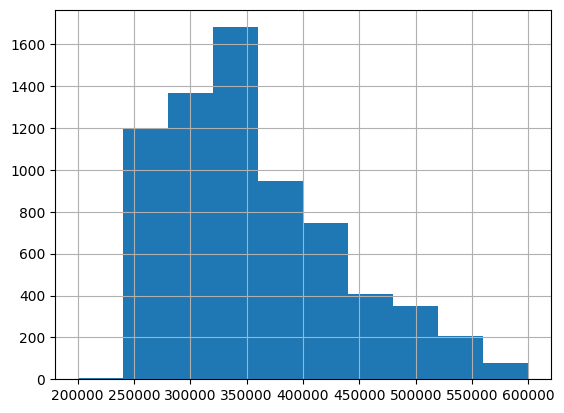

In [25]:
#########################
# "MonthlyIncome"の処理 #
#########################
import re

# 漢字の判定用
p = re.compile('[月]+')

# nanを-1で補完
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].fillna("-1")

for i in range(max_row):

  # 先頭文字の取得
  head = all_df.loc[i,"MonthlyIncome"][:1]

  # 先頭文字が漢字の場合
  if(p.search(head[0])!=None):
    tmp = all_df.loc[i,"MonthlyIncome"][2:-2]
    all_df.loc[i,"MonthlyIncome"] = float(tmp)*10000

# float型にキャストする
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].astype(float)

# 「-1」はそれ以外の中央値を代入
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].replace(-1,all_df.loc[all_df["MonthlyIncome"]>0,"MonthlyIncome"].median())

# 分布の確認
all_df["MonthlyIncome"].hist()

In [26]:
#########################
# "customer_info"の処理 #
#########################
import re

# 項目名
cont = []

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      if(tmp[j] not in cont):
        cont.append(tmp[j])

# キーワード抽出
c_car = [] # 車関係
c_child = [] # 子供関係
c_married = [] # 婚姻関係
c_other = [] # その他

for i in range(len(cont)):
  # 「車あり」、「車所持」、「自家用車あり」、「車保有」、「乗用車所持」、「自動車保有」
  # 「車なし」、「車未所持」、「自家用車なし」、「車保有なし」、「乗用車なし」、「自動車未所有」
  if((cont[i][0:1] == "車") or (cont[i][0:1] == "自") or (cont[i][0:1] == "乗")):
    c_car.append(cont[i])
  # 「こども1人」、「1児」、「子供1人」、「子供有り(1人)」、「子供有り」
  # 「こども2人」、「2児」、「子供2人」、「子供有り(2人)」
  # 「こども3人」、「3児」「子供3人」、「子供有り(3人)」
  # 「子供なし」、「子供無し」、「無子」、「子供ゼロ」、「非児童家庭」
  # 「子育て状況不明」、「子の数不詳」、「子供の数不明」
  elif((cont[i][0:1] == "子") or (cont[i][0:1] == "こ") or (cont[i][-1:] == "児") or (cont[i][-1:] == "子") or (cont[i][-1:] == "庭")):
    c_child.append(cont[i])
  # 「結婚済み」、「離婚済み」、「未婚」、「独身」
  elif((cont[i][0:1] == "結") or (cont[i][0:1] == "離") or (cont[i][0:1] == "独") or (cont[i][0:1] == "離") or (cont[i][0:1] == "未")):
    c_married.append(cont[i])
  # 「1人」、「2人」、「3人」、「不明」、「わからない」
  else:
    c_other.append(cont[i])

In [27]:
# 新たなカラムを追加
all_df["CarHolder"] = 0 # 車所有
all_df["NumofChild"] = 0 # 子供の数
all_df["Married"] = "Single" # 婚姻歴

# 車
c_car_hold = ["車あり","車所持","自家用車あり","車保有","乗用車所持","自動車保有"]

# 子供
c_child_1 = ["こども1人","1児""子供1人","子供有り(1人)","子供有り"]
c_child_2 = ["こども2人","2児""子供2人","子供有り(2人)"]
c_child_3 = ["こども3人","3児""子供3人","子供有り(3人)"]

# 婚姻状況
c_pair = ["結婚済み"]
c_batu = ["離婚済み"]

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      # 車の情報
      if(tmp[j] in c_car_hold):
        all_df.loc[i, "CarHolder"] = 1
      # 子供の情報
      if(tmp[j] in c_child_1):
        all_df.loc[i, "NumofChild"] = 1
      if(tmp[j] in c_child_2):
        all_df.loc[i, "NumofChild"] = 2
      if(tmp[j] in c_child_3):
        all_df.loc[i, "NumofChild"] = 3
      # 婚姻歴
      if(tmp[j] in c_pair):
        all_df.loc[i, "Married"] = "Married"
      if(tmp[j] in c_batu):
        all_df.loc[i, "Married"] = "Divorce"

# 使用済みカラム抹消
all_df = all_df.drop("customer_info", axis=1)

In [28]:
# 車保有率
print(all_df["CarHolder"].value_counts())

CarHolder
0    4408
1    2570
Name: count, dtype: int64


In [29]:
# 子供の数
print(all_df["NumofChild"].value_counts())

NumofChild
0    5015
1    1347
2     571
3      45
Name: count, dtype: int64


In [30]:
# 婚姻歴

# 特徴量を追加する
all_df["Family"] = 0
all_df["Single"] = 0
all_df["Divorce"] = 0

# one-hot化して追加する
all_df.loc[all_df["Married"]=="Married","Family"] = 1
all_df.loc[all_df["Married"]=="Single","Single"] = 1
all_df.loc[all_df["Married"]=="Divorce","Divorce"] = 1

# 元のカラムを削除する
all_df = all_df.drop("Married", axis=1)

print(all_df["Family"].value_counts())
print(all_df["Single"].value_counts())
print(all_df["Divorce"].value_counts())

Family
0    4132
1    2846
Name: count, dtype: int64
Single
0    4534
1    2444
Name: count, dtype: int64
Divorce
0    5290
1    1688
Name: count, dtype: int64


In [31]:
all_df.columns

Index(['id', 'Age', 'CompanyInvited', 'CityTier', 'DurationOfPitch', 'Male',
       'NumberOfPersonVisiting', 'NumberOfFollowups', 'ProductPitched',
       'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'ProdTaken',
       'SmallBusiness', 'Salaried', 'LargeBusiness', 'CarHolder', 'NumofChild',
       'Family', 'Single', 'Divorce'],
      dtype='object')

In [32]:
# 順番を整列させる
col = ['id', 'Age', "CompanyInvited", 'CityTier', 'DurationOfPitch',
       'SmallBusiness', 'Salaried', 'LargeBusiness',
       'Male', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', "CarHolder",
       "NumofChild", 'Family', 'Single', 'Divorce',
       'ProdTaken']

all_df = all_df.reindex(columns=col)

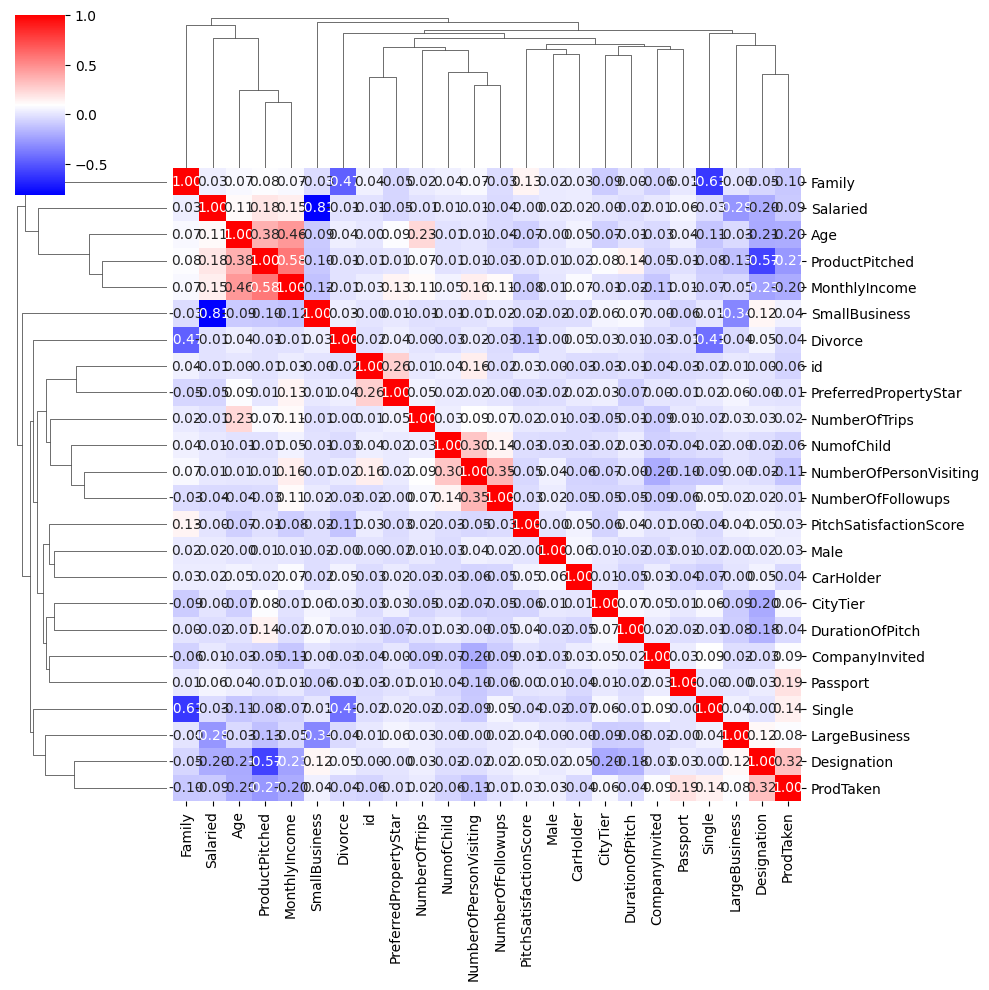

In [33]:
# 相関係数を確認する
import seaborn as sns
import matplotlib.pyplot as plt

all_df_corr = all_df.corr()
sns.clustermap(all_df_corr,annot=True,fmt=".2f",cmap="bwr")
plt.show()

In [34]:
# "Salaried" と "SmallBusiness" が0.6 超えるため、サラリーマンかそうでないかに分ける
all_df = all_df.drop("SmallBusiness", axis=1)
all_df = all_df.drop("LargeBusiness", axis=1)

In [35]:
# "Family" と "Single" が0.6 超えるため、独身かそうでないかに分ける
all_df = all_df.drop("Family", axis=1)
all_df = all_df.drop("Divorce", axis=1)

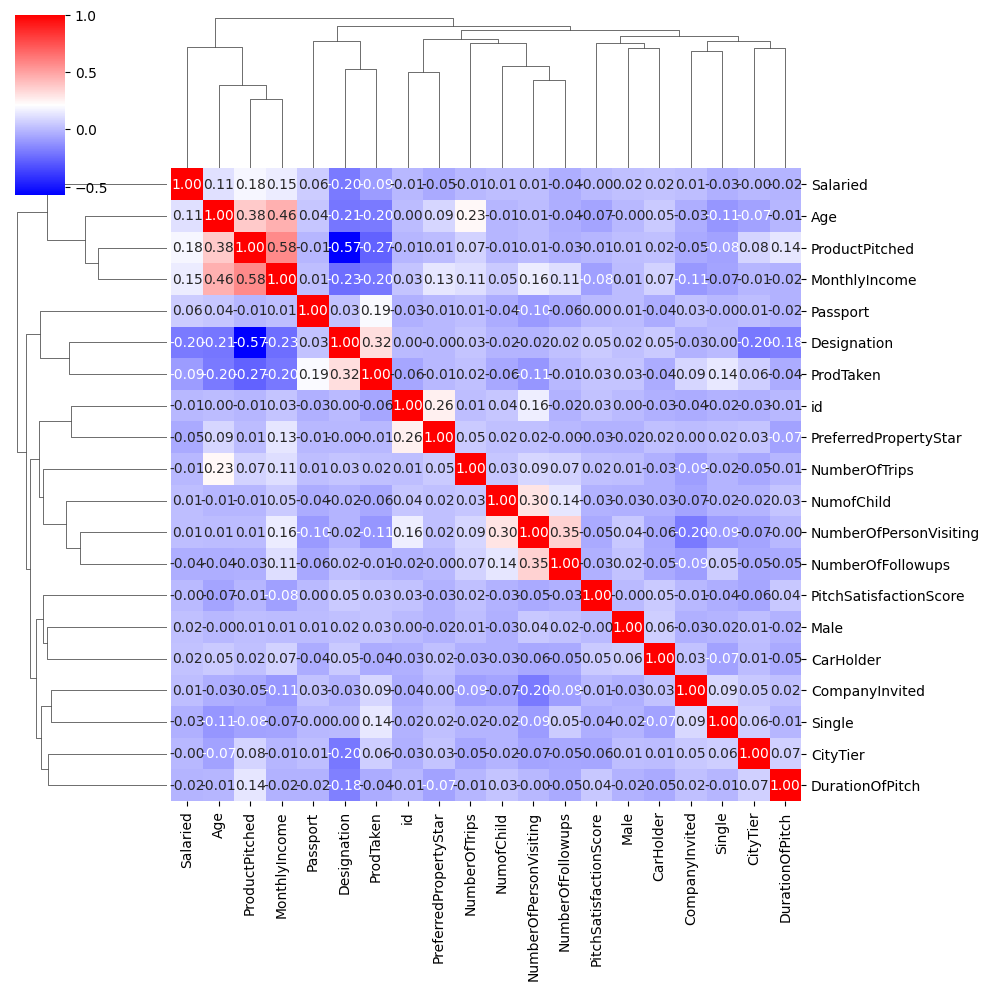

In [36]:
# 相関係数がすべて0.6未満に収まったので次のステップに進む
all_df_corr = all_df.corr()
sns.clustermap(all_df_corr,annot=True,fmt=".2f",cmap="bwr")
plt.show()

# 特徴量エンジニアリング

In [37]:
#-------------------------------------------------------------------------------------------
# カテゴリ列 x 13
# CompanyInvited, CityTier, DurationOfPitch, Salaried, Male, ProductPitched, PreferredPropertyStar,
# NumberOfTrips, Passport, PitchSatisfactionScore, Designation, CarHolder, Single
# 数値列 x 5
# Age, NumberOfPersonVisiting, NumberOfFollowups, MonthlyIncome, NumofChild
#-------------------------------------------------------------------------------------------
all_df.columns

Index(['id', 'Age', 'CompanyInvited', 'CityTier', 'DurationOfPitch',
       'Salaried', 'Male', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'CarHolder',
       'NumofChild', 'Single', 'ProdTaken'],
      dtype='object')

In [38]:
# クロス特徴量の追加
# 「役職」x「商品ランク」
all_df["Designation_ProductPitched"] = all_df["Designation"] * all_df["ProductPitched"]

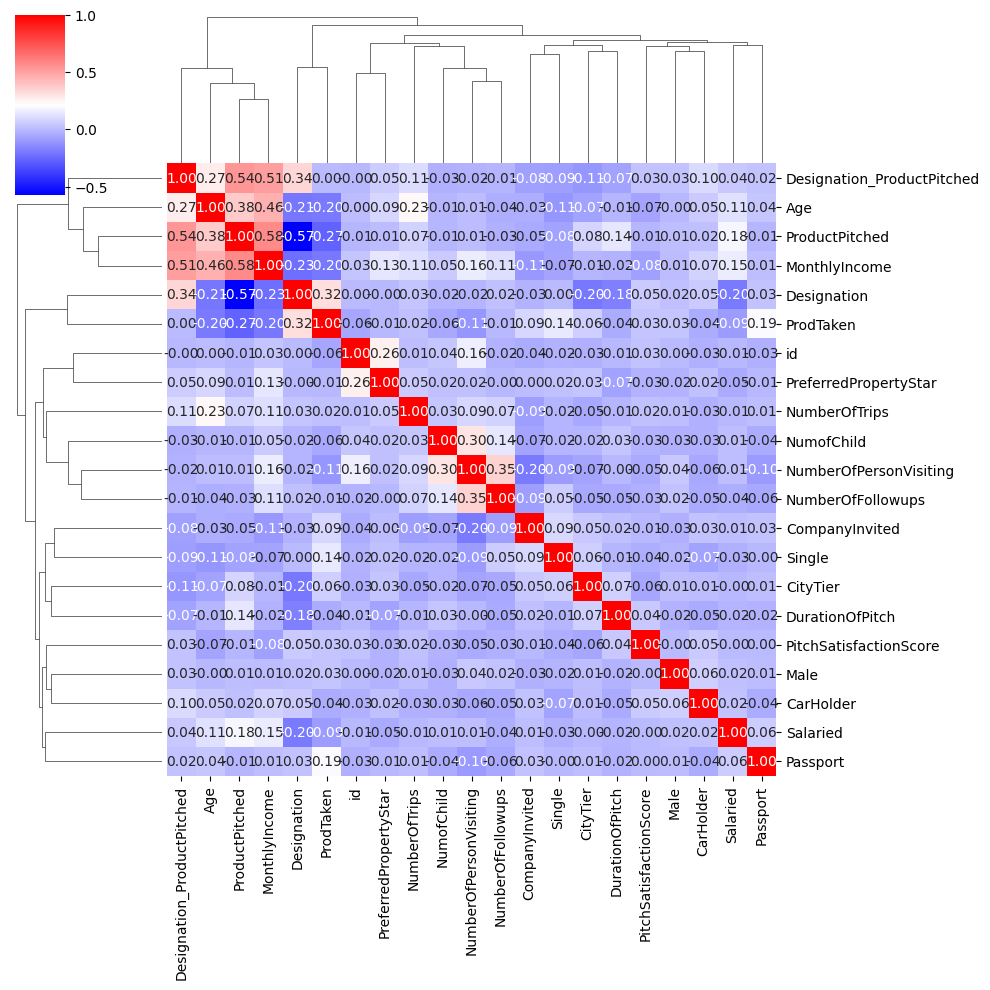

In [39]:
# 相関係数の確認OK
all_df_corr = all_df.corr()
sns.clustermap(all_df_corr,annot=True,fmt=".2f",cmap="bwr")
plt.show()

In [40]:
all_df.columns

Index(['id', 'Age', 'CompanyInvited', 'CityTier', 'DurationOfPitch',
       'Salaried', 'Male', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'CarHolder',
       'NumofChild', 'Single', 'ProdTaken', 'Designation_ProductPitched'],
      dtype='object')

In [41]:
# 古い列を削除
all_df = all_df.drop("Salaried", axis=1)

In [54]:
# 順番を整列させる
col = ['id', 'Age', 'CompanyInvited', 'CityTier', 'DurationOfPitch',
       'Designation_ProductPitched', 'Male', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'CarHolder',
       'NumofChild', 'Single', 'ProdTaken']

all_df = all_df.reindex(columns=col)

In [ ]:
# 検討の結果、重要度が低いものを抹消する
# all_df = all_df.drop("Occupation_LE", axis=1)

In [ ]:
# 月収、年齢はLogを取る
# all_df["MonthlyIncomeLOG"] = np.log1p(all_df["MonthlyIncome"])
# all_df["AgeLOG"] = np.log1p(all_df["Age"])

# # 元の列削除
# all_df = all_df.drop("Age", axis=1)
# all_df = all_df.drop("MonthlyIncome", axis=1)

# ここから学習作業

In [57]:
# 取り除く変数
RMV = ["id","ProdTaken"]
RMV2 = ["id"]

FEATURES = [c for c in all_df.columns if c not in RMV2]
TARGET = "ProdTaken"

In [58]:
CATS = []
for c in FEATURES:
  if all_df[c].dtype == "object":
    CATS.append(c)
print(CATS)

[]


In [59]:
# オブジェクト型はint型に変換する
all_df[CATS] = all_df[CATS].astype(int)

In [60]:
# カラムを制限
all_df2 = all_df[FEATURES]

# 結合を戻す
train = all_df2.iloc[:len(train_df)].copy()
test = all_df2.iloc[len(train_df):].reset_index(drop=True).copy()

# 対象の列のみ取り込み
test = test.drop(TARGET,axis=1)
FEATURES = test.columns

In [61]:
# Optunaを使用する
import optuna
import lightgbm as lgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

FOLDS = 3 # 分割数
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

def objective(trial):

  lgbm_params = {
      'objective': 'binary',
      "device": "cpu",
      'metric': 'auc',
      'verbose': -1,              # ログ出力の制御
      'boosting_type': 'gbdt',
      'learning_rate': 0.1,

      'num_leaves': trial.suggest_int('num_leaves', 16, 256),
      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
      'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
      'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1),
      'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
      'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0,log=True),
      'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0,log=True),
      'max_depth': trial.suggest_int('max_depth', 3, 12),

      # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
      }

  for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    # インデックスに割り振る

    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, TARGET]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, TARGET]
    # x_test = test[FEATURES].copy()

    # データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          num_boost_round = 2000,
                          valid_sets = [lgb_train, lgb_eval],
                          valid_names = ["train", "valid"],
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              # lgb.record_evaluation(evaluations_result),
                              lgb.log_evaluation(100),])

    oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

  score = roc_auc_score(train[TARGET],oof_lgb)

  return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2025-05-26 10:57:55,563] A new study created in memory with name: no-name-b0555557-4b9b-4955-acf3-663cae7036da
<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.997889	valid's auc: 0.784704
#########################
### Fold 2
#########################
[100]	train's auc: 0.997557	valid's auc: 0.768045
#########################
### Fold 3
#########################


[I 2025-05-26 10:57:56,787] Trial 0 finished with value: 0.7955328898524838 and parameters: {'num_leaves': 122, 'min_data_in_leaf': 13, 'feature_fraction': 0.9454517676779488, 'bagging_fraction': 0.8322758746525594, 'bagging_freq': 5, 'lambda_l1': 3.127873522557272e-05, 'lambda_l2': 0.0002710999908161142, 'max_depth': 7}. Best is trial 0 with value: 0.7955328898524838.


[100]	train's auc: 0.996902	valid's auc: 0.789002
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.897482	valid's auc: 0.82631
#########################
### Fold 2
#########################
[100]	train's auc: 0.916008	valid's auc: 0.79251
#########################
### Fold 3
#########################
[100]	train's auc: 0.905527	valid's auc: 0.825305


[I 2025-05-26 10:57:57,468] Trial 1 finished with value: 0.8198230156339104 and parameters: {'num_leaves': 242, 'min_data_in_leaf': 14, 'feature_fraction': 0.8567565277941852, 'bagging_fraction': 0.6311128191568636, 'bagging_freq': 4, 'lambda_l1': 4.1947601351660916e-08, 'lambda_l2': 6.659953016616394e-07, 'max_depth': 3}. Best is trial 1 with value: 0.8198230156339104.
<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.933603	valid's auc: 0.811132
#########################
### Fold 2
#########################
[100]	train's auc: 0.943401	valid's auc: 0.780486
#########################
### Fold 3
#########################


[I 2025-05-26 10:57:58,196] Trial 2 finished with value: 0.8121876311344 and parameters: {'num_leaves': 90, 'min_data_in_leaf': 11, 'feature_fraction': 0.5087261632342873, 'bagging_fraction': 0.5045579206373197, 'bagging_freq': 5, 'lambda_l1': 1.2263884093343424e-08, 'lambda_l2': 0.006130312922356231, 'max_depth': 4}. Best is trial 1 with value: 0.8198230156339104.


[100]	train's auc: 0.934105	valid's auc: 0.807469
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.924337	valid's auc: 0.823186
#########################
### Fold 2
#########################
[100]	train's auc: 0.934658	valid's auc: 0.795876
#########################
### Fold 3
#########################


[I 2025-05-26 10:57:59,018] Trial 3 finished with value: 0.8233834827144686 and parameters: {'num_leaves': 107, 'min_data_in_leaf': 40, 'feature_fraction': 0.7519660457196373, 'bagging_fraction': 0.7061338862104389, 'bagging_freq': 1, 'lambda_l1': 6.627700557309749e-08, 'lambda_l2': 0.16615632348456005, 'max_depth': 4}. Best is trial 3 with value: 0.8233834827144686.


[100]	train's auc: 0.930655	valid's auc: 0.826101
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.997218	valid's auc: 0.768347
#########################
### Fold 2
#########################
[100]	train's auc: 0.99758	valid's auc: 0.771803
#########################
### Fold 3
#########################


[I 2025-05-26 10:58:00,228] Trial 4 finished with value: 0.7960742395549769 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 15, 'feature_fraction': 0.9764846217203113, 'bagging_fraction': 0.5529651037733851, 'bagging_freq': 6, 'lambda_l1': 1.3881708407774577e-08, 'lambda_l2': 0.00012983145632184, 'max_depth': 9}. Best is trial 3 with value: 0.8233834827144686.


[100]	train's auc: 0.995687	valid's auc: 0.796885
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.991149	valid's auc: 0.796002
#########################
### Fold 2
#########################
[100]	train's auc: 0.992519	valid's auc: 0.774226
#########################
### Fold 3
#########################


[I 2025-05-26 10:58:02,102] Trial 5 finished with value: 0.8172988465552674 and parameters: {'num_leaves': 195, 'min_data_in_leaf': 13, 'feature_fraction': 0.5850394686812458, 'bagging_fraction': 0.5969697353737684, 'bagging_freq': 5, 'lambda_l1': 0.6451830669026093, 'lambda_l2': 0.019627929241162842, 'max_depth': 10}. Best is trial 3 with value: 0.8233834827144686.


[100]	train's auc: 0.990334	valid's auc: 0.793611
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.969542	valid's auc: 0.813253
#########################
### Fold 2
#########################
[100]	train's auc: 0.972793	valid's auc: 0.785332
#########################
### Fold 3
#########################


[I 2025-05-26 10:58:02,945] Trial 6 finished with value: 0.8201915369220673 and parameters: {'num_leaves': 131, 'min_data_in_leaf': 71, 'feature_fraction': 0.6491588491772418, 'bagging_fraction': 0.8962161909772939, 'bagging_freq': 5, 'lambda_l1': 4.081981149026245e-05, 'lambda_l2': 0.0019841224960399874, 'max_depth': 11}. Best is trial 3 with value: 0.8233834827144686.


[100]	train's auc: 0.967778	valid's auc: 0.822912
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.926914	valid's auc: 0.825797
#########################
### Fold 2
#########################
[100]	train's auc: 0.935802	valid's auc: 0.794552
#########################
### Fold 3
#########################
[100]	train's auc: 0.92409	valid's auc: 0.82686


[I 2025-05-26 10:58:07,648] Trial 7 finished with value: 0.8200190447497822 and parameters: {'num_leaves': 122, 'min_data_in_leaf': 62, 'feature_fraction': 0.8153889572604553, 'bagging_fraction': 0.9650366822562102, 'bagging_freq': 4, 'lambda_l1': 2.7024699140871746, 'lambda_l2': 0.23879585641552206, 'max_depth': 10}. Best is trial 3 with value: 0.8233834827144686.
<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.998614	valid's auc: 0.794987
#########################
### Fold 2
#########################
[100]	train's auc: 0.998107	valid's auc: 0.77648
#########################
### Fold 3
#########################


[I 2025-05-26 10:58:08,710] Trial 8 finished with value: 0.8061978152336479 and parameters: {'num_leaves': 94, 'min_data_in_leaf': 24, 'feature_fraction': 0.7399407433284373, 'bagging_fraction': 0.750914667962649, 'bagging_freq': 4, 'lambda_l1': 0.0018176722422602435, 'lambda_l2': 0.003567631932890417, 'max_depth': 10}. Best is trial 3 with value: 0.8233834827144686.


[100]	train's auc: 0.996704	valid's auc: 0.798743
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.961743	valid's auc: 0.817833
#########################
### Fold 2
#########################
[100]	train's auc: 0.963777	valid's auc: 0.788661
#########################
### Fold 3
#########################


[I 2025-05-26 10:58:09,690] Trial 9 finished with value: 0.8167733002291827 and parameters: {'num_leaves': 255, 'min_data_in_leaf': 46, 'feature_fraction': 0.5646904838471063, 'bagging_fraction': 0.8872916983091299, 'bagging_freq': 6, 'lambda_l1': 9.586975299543593e-05, 'lambda_l2': 2.186807189785144, 'max_depth': 8}. Best is trial 3 with value: 0.8233834827144686.


[100]	train's auc: 0.960552	valid's auc: 0.825481
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.914278	valid's auc: 0.831126
#########################
### Fold 2
#########################
[100]	train's auc: 0.922218	valid's auc: 0.800274
#########################
### Fold 3
#########################


[I 2025-05-26 10:58:10,580] Trial 10 finished with value: 0.8289106295527174 and parameters: {'num_leaves': 21, 'min_data_in_leaf': 97, 'feature_fraction': 0.7004167772720875, 'bagging_fraction': 0.6995874647921678, 'bagging_freq': 1, 'lambda_l1': 1.7061662050825336e-06, 'lambda_l2': 4.491761128584266e-08, 'max_depth': 5}. Best is trial 10 with value: 0.8289106295527174.


[100]	train's auc: 0.91362	valid's auc: 0.830042
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.911071	valid's auc: 0.831434
#########################
### Fold 2
#########################
[100]	train's auc: 0.922474	valid's auc: 0.798244
#########################
### Fold 3
#########################


[I 2025-05-26 10:58:11,348] Trial 11 finished with value: 0.8257755086669751 and parameters: {'num_leaves': 16, 'min_data_in_leaf': 99, 'feature_fraction': 0.7226748817238621, 'bagging_fraction': 0.7376761863649433, 'bagging_freq': 1, 'lambda_l1': 1.2585250943152486e-06, 'lambda_l2': 2.220029486353781e-08, 'max_depth': 5}. Best is trial 10 with value: 0.8289106295527174.


[100]	train's auc: 0.914977	valid's auc: 0.828293
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.917669	valid's auc: 0.828117
#########################
### Fold 2
#########################
[100]	train's auc: 0.929491	valid's auc: 0.799253
#########################
### Fold 3
#########################


[I 2025-05-26 10:58:12,259] Trial 12 finished with value: 0.8230885984355331 and parameters: {'num_leaves': 26, 'min_data_in_leaf': 100, 'feature_fraction': 0.6869659018191824, 'bagging_fraction': 0.7217349725335429, 'bagging_freq': 1, 'lambda_l1': 1.8748662233200057e-06, 'lambda_l2': 1.881082166609866e-08, 'max_depth': 6}. Best is trial 10 with value: 0.8289106295527174.


[100]	train's auc: 0.916643	valid's auc: 0.829034
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.925232	valid's auc: 0.824238
#########################
### Fold 2
#########################
[100]	train's auc: 0.93295	valid's auc: 0.800498
#########################
### Fold 3
#########################


[I 2025-05-26 10:58:13,171] Trial 13 finished with value: 0.8249127115634987 and parameters: {'num_leaves': 18, 'min_data_in_leaf': 97, 'feature_fraction': 0.6811050988128702, 'bagging_fraction': 0.7892011411185254, 'bagging_freq': 2, 'lambda_l1': 1.9822291393750228e-06, 'lambda_l2': 1.0573617598526229e-08, 'max_depth': 6}. Best is trial 10 with value: 0.8289106295527174.


[100]	train's auc: 0.924625	valid's auc: 0.824364
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.908728	valid's auc: 0.833368
#########################
### Fold 2
#########################
[100]	train's auc: 0.926375	valid's auc: 0.797942
#########################
### Fold 3
#########################


[I 2025-05-26 10:58:14,030] Trial 14 finished with value: 0.8227994302714685 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 89, 'feature_fraction': 0.8267077397600407, 'bagging_fraction': 0.6693499537116492, 'bagging_freq': 2, 'lambda_l1': 0.002477510717613672, 'lambda_l2': 3.1305492717443713e-06, 'max_depth': 5}. Best is trial 10 with value: 0.8289106295527174.


[100]	train's auc: 0.915904	valid's auc: 0.823113
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.927021	valid's auc: 0.823053
#########################
### Fold 2
#########################
[100]	train's auc: 0.938671	valid's auc: 0.796244
#########################
### Fold 3
#########################


[I 2025-05-26 10:58:14,865] Trial 15 finished with value: 0.8188368176976295 and parameters: {'num_leaves': 173, 'min_data_in_leaf': 80, 'feature_fraction': 0.7486723430790544, 'bagging_fraction': 0.8018791158450099, 'bagging_freq': 2, 'lambda_l1': 1.9042196744138763e-06, 'lambda_l2': 5.781413764914771e-07, 'max_depth': 5}. Best is trial 10 with value: 0.8289106295527174.


[100]	train's auc: 0.927353	valid's auc: 0.813973
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.877408	valid's auc: 0.837567
#########################
### Fold 2
#########################
[100]	train's auc: 0.891193	valid's auc: 0.803181
#########################
### Fold 3
#########################
[100]	train's auc: 0.879162	valid's auc: 0.835167


[I 2025-05-26 10:58:15,564] Trial 16 finished with value: 0.827820532822604 and parameters: {'num_leaves': 70, 'min_data_in_leaf': 84, 'feature_fraction': 0.6223243834146048, 'bagging_fraction': 0.6683689643426242, 'bagging_freq': 3, 'lambda_l1': 7.071858681411471e-07, 'lambda_l2': 6.542625506779254e-06, 'max_depth': 3}. Best is trial 10 with value: 0.8289106295527174.
<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.877746	valid's auc: 0.835265
#########################
### Fold 2
#########################
[100]	train's auc: 0.892546	valid's auc: 0.798015
#########################
### Fold 3
#########################
[100]	train's auc: 0.878825	valid's auc: 0.836424


[I 2025-05-26 10:58:16,265] Trial 17 finished with value: 0.8261124232023154 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 82, 'feature_fraction': 0.6097371801194647, 'bagging_fraction': 0.6485669766944697, 'bagging_freq': 3, 'lambda_l1': 0.02270321405612652, 'lambda_l2': 5.515174193370774e-06, 'max_depth': 3}. Best is trial 10 with value: 0.8289106295527174.
<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.88226	valid's auc: 0.830606
#########################
### Fold 2
#########################
[100]	train's auc: 0.892271	valid's auc: 0.799809
#########################
### Fold 3
#########################
[100]	train's auc: 0.881192	valid's auc: 0.838623


[I 2025-05-26 10:58:17,040] Trial 18 finished with value: 0.828679631263517 and parameters: {'num_leaves': 68, 'min_data_in_leaf': 68, 'feature_fraction': 0.5064324252859813, 'bagging_fraction': 0.5776887104178838, 'bagging_freq': 3, 'lambda_l1': 2.4801541732856484e-07, 'lambda_l2': 2.4733625758066022e-05, 'max_depth': 3}. Best is trial 10 with value: 0.8289106295527174.
<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.930783	valid's auc: 0.827144
#########################
### Fold 2
#########################
[100]	train's auc: 0.935004	valid's auc: 0.802335
#########################
### Fold 3
#########################


[I 2025-05-26 10:58:21,801] Trial 19 finished with value: 0.8283807120799664 and parameters: {'num_leaves': 36, 'min_data_in_leaf': 64, 'feature_fraction': 0.5064120181070284, 'bagging_fraction': 0.5719097580351634, 'bagging_freq': 7, 'lambda_l1': 1.8606259195513332e-07, 'lambda_l2': 1.5899046050078544e-07, 'max_depth': 7}. Best is trial 10 with value: 0.8289106295527174.


[100]	train's auc: 0.924951	valid's auc: 0.826429
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.908799	valid's auc: 0.809017
#########################
### Fold 2
#########################
[100]	train's auc: 0.917019	valid's auc: 0.800123
#########################
### Fold 3
#########################
[100]	train's auc: 0.909489	valid's auc: 0.822821


[I 2025-05-26 10:58:22,806] Trial 20 finished with value: 0.8244339028825358 and parameters: {'num_leaves': 160, 'min_data_in_leaf': 49, 'feature_fraction': 0.9002795190037709, 'bagging_fraction': 0.5213523190889685, 'bagging_freq': 3, 'lambda_l1': 1.3389644093871933e-05, 'lambda_l2': 7.304994465089616e-05, 'max_depth': 4}. Best is trial 10 with value: 0.8289106295527174.
<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.930995	valid's auc: 0.815489
#########################
### Fold 2
#########################
[100]	train's auc: 0.934657	valid's auc: 0.801277
#########################
### Fold 3
#########################


[I 2025-05-26 10:58:23,936] Trial 21 finished with value: 0.8278908074113129 and parameters: {'num_leaves': 39, 'min_data_in_leaf': 62, 'feature_fraction': 0.5096620219974057, 'bagging_fraction': 0.5683068957800811, 'bagging_freq': 7, 'lambda_l1': 1.5991191686488054e-07, 'lambda_l2': 1.6135120130496155e-07, 'max_depth': 7}. Best is trial 10 with value: 0.8289106295527174.


[100]	train's auc: 0.924196	valid's auc: 0.821686
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.923853	valid's auc: 0.81796
#########################
### Fold 2
#########################
[100]	train's auc: 0.927494	valid's auc: 0.798105
#########################
### Fold 3
#########################


[I 2025-05-26 10:58:24,927] Trial 22 finished with value: 0.8257593690485157 and parameters: {'num_leaves': 77, 'min_data_in_leaf': 73, 'feature_fraction': 0.5335872495037193, 'bagging_fraction': 0.5994221253339475, 'bagging_freq': 7, 'lambda_l1': 2.3408880082427112e-07, 'lambda_l2': 1.1750863498284091e-07, 'max_depth': 6}. Best is trial 10 with value: 0.8289106295527174.


[100]	train's auc: 0.917996	valid's auc: 0.829101
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.940448	valid's auc: 0.823289
#########################
### Fold 2
#########################
[100]	train's auc: 0.947311	valid's auc: 0.790407
#########################
### Fold 3
#########################


[I 2025-05-26 10:58:25,835] Trial 23 finished with value: 0.8255431654095697 and parameters: {'num_leaves': 36, 'min_data_in_leaf': 62, 'feature_fraction': 0.5558061056141796, 'bagging_fraction': 0.6067511071451046, 'bagging_freq': 2, 'lambda_l1': 5.774021615953776e-06, 'lambda_l2': 1.3460749900432068e-07, 'max_depth': 8}. Best is trial 10 with value: 0.8289106295527174.


[100]	train's auc: 0.940974	valid's auc: 0.822609
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.914978	valid's auc: 0.814812
#########################
### Fold 2
#########################
[100]	train's auc: 0.921112	valid's auc: 0.791259
#########################
### Fold 3
#########################


[I 2025-05-26 10:58:26,625] Trial 24 finished with value: 0.8276836823077502 and parameters: {'num_leaves': 46, 'min_data_in_leaf': 34, 'feature_fraction': 0.5009980933865092, 'bagging_fraction': 0.5402514321611801, 'bagging_freq': 6, 'lambda_l1': 2.737802712249767e-07, 'lambda_l2': 4.0810636284087895e-05, 'max_depth': 4}. Best is trial 10 with value: 0.8289106295527174.


[100]	train's auc: 0.919253	valid's auc: 0.829902
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.943963	valid's auc: 0.816268
#########################
### Fold 2
#########################
[100]	train's auc: 0.949392	valid's auc: 0.789604
#########################
### Fold 3
#########################


[I 2025-05-26 10:58:27,537] Trial 25 finished with value: 0.8270377613273223 and parameters: {'num_leaves': 78, 'min_data_in_leaf': 72, 'feature_fraction': 0.5925665873870409, 'bagging_fraction': 0.6854442886910895, 'bagging_freq': 3, 'lambda_l1': 0.00016940359384180734, 'lambda_l2': 1.7466824695543716e-05, 'max_depth': 12}. Best is trial 10 with value: 0.8289106295527174.


[100]	train's auc: 0.944031	valid's auc: 0.823702
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.931275	valid's auc: 0.825664
#########################
### Fold 2
#########################
[100]	train's auc: 0.94	valid's auc: 0.795211
#########################
### Fold 3
#########################


[I 2025-05-26 10:58:28,329] Trial 26 finished with value: 0.8220442306243881 and parameters: {'num_leaves': 41, 'min_data_in_leaf': 54, 'feature_fraction': 0.656467487443235, 'bagging_fraction': 0.6334900032513975, 'bagging_freq': 1, 'lambda_l1': 0.0008017634528868344, 'lambda_l2': 7.654681570989244e-07, 'max_depth': 5}. Best is trial 10 with value: 0.8289106295527174.


[100]	train's auc: 0.936327	valid's auc: 0.819828
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.913571	valid's auc: 0.829573
#########################
### Fold 2
#########################
[100]	train's auc: 0.918111	valid's auc: 0.799743
#########################
### Fold 3
#########################


[I 2025-05-26 10:58:29,066] Trial 27 finished with value: 0.8220385145095169 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 90, 'feature_fraction': 0.7892644258711289, 'bagging_fraction': 0.5775599284876352, 'bagging_freq': 4, 'lambda_l1': 5.9446012981884895e-06, 'lambda_l2': 6.20813320416937e-08, 'max_depth': 7}. Best is trial 10 with value: 0.8289106295527174.


[100]	train's auc: 0.913148	valid's auc: 0.826174
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.941903	valid's auc: 0.824099
#########################
### Fold 2
#########################
[100]	train's auc: 0.947138	valid's auc: 0.798021
#########################
### Fold 3
#########################


[I 2025-05-26 10:58:29,954] Trial 28 finished with value: 0.8259133679079828 and parameters: {'num_leaves': 96, 'min_data_in_leaf': 67, 'feature_fraction': 0.5464752089378707, 'bagging_fraction': 0.7733626232156391, 'bagging_freq': 2, 'lambda_l1': 3.4677154350563885e-08, 'lambda_l2': 1.2694171672875596e-06, 'max_depth': 6}. Best is trial 10 with value: 0.8289106295527174.


[100]	train's auc: 0.939866	valid's auc: 0.818139
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.960056	valid's auc: 0.805181
#########################
### Fold 2
#########################
[100]	train's auc: 0.964232	valid's auc: 0.797132
#########################
### Fold 3
#########################


[I 2025-05-26 10:58:30,843] Trial 29 finished with value: 0.8190970690452878 and parameters: {'num_leaves': 154, 'min_data_in_leaf': 76, 'feature_fraction': 0.9044539152586799, 'bagging_fraction': 0.8372478207865014, 'bagging_freq': 7, 'lambda_l1': 1.52876735039686e-05, 'lambda_l2': 0.00044401551020411493, 'max_depth': 8}. Best is trial 10 with value: 0.8289106295527174.


[100]	train's auc: 0.957289	valid's auc: 0.811812
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.88307	valid's auc: 0.823942
#########################
### Fold 2
#########################
[100]	train's auc: 0.898874	valid's auc: 0.7988
#########################
### Fold 3
#########################
[100]	train's auc: 0.884365	valid's auc: 0.828609


[I 2025-05-26 10:58:31,527] Trial 30 finished with value: 0.8221629240684751 and parameters: {'num_leaves': 32, 'min_data_in_leaf': 55, 'feature_fraction': 0.6349525277653749, 'bagging_fraction': 0.536066704292619, 'bagging_freq': 5, 'lambda_l1': 3.960918519664885e-07, 'lambda_l2': 0.0006915207691559641, 'max_depth': 3}. Best is trial 10 with value: 0.8289106295527174.
<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.930998	valid's auc: 0.816171
#########################
### Fold 2
#########################
[100]	train's auc: 0.935452	valid's auc: 0.797755
#########################
### Fold 3
#########################
[100]	train's auc: 0.924617	valid's auc: 0.825506


[I 2025-05-26 10:58:36,128] Trial 31 finished with value: 0.8290071310214226 and parameters: {'num_leaves': 38, 'min_data_in_leaf': 61, 'feature_fraction': 0.5216251211637566, 'bagging_fraction': 0.5653550897349159, 'bagging_freq': 7, 'lambda_l1': 1.331736262323375e-07, 'lambda_l2': 2.2746035612096707e-07, 'max_depth': 7}. Best is trial 31 with value: 0.8290071310214226.
<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.931516	valid's auc: 0.817416
#########################
### Fold 2
#########################
[100]	train's auc: 0.943234	valid's auc: 0.79474
#########################
### Fold 3
#########################


[I 2025-05-26 10:58:37,009] Trial 32 finished with value: 0.8249823136681049 and parameters: {'num_leaves': 16, 'min_data_in_leaf': 65, 'feature_fraction': 0.5323103711034838, 'bagging_fraction': 0.6260415380595099, 'bagging_freq': 6, 'lambda_l1': 7.627168235098066e-08, 'lambda_l2': 3.6124692659127744e-07, 'max_depth': 7}. Best is trial 31 with value: 0.8290071310214226.


[100]	train's auc: 0.935019	valid's auc: 0.829344
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.941867	valid's auc: 0.817845
#########################
### Fold 2
#########################
[100]	train's auc: 0.943835	valid's auc: 0.786172
#########################
### Fold 3
#########################


[I 2025-05-26 10:58:37,933] Trial 33 finished with value: 0.8224873976479196 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 50, 'feature_fraction': 0.5773803551928608, 'bagging_fraction': 0.5153281399050506, 'bagging_freq': 7, 'lambda_l1': 1.056639369986262e-08, 'lambda_l2': 3.578373731877375e-08, 'max_depth': 9}. Best is trial 31 with value: 0.8290071310214226.


[100]	train's auc: 0.945093	valid's auc: 0.812285
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.927574	valid's auc: 0.816171
#########################
### Fold 2
#########################
[100]	train's auc: 0.934911	valid's auc: 0.787459
#########################
### Fold 3
#########################


[I 2025-05-26 10:58:38,815] Trial 34 finished with value: 0.8246359843553299 and parameters: {'num_leaves': 111, 'min_data_in_leaf': 56, 'feature_fraction': 0.5289957113080704, 'bagging_fraction': 0.5000358547491633, 'bagging_freq': 7, 'lambda_l1': 6.658640944315468e-08, 'lambda_l2': 2.4005827345741335e-06, 'max_depth': 7}. Best is trial 31 with value: 0.8290071310214226.


[100]	train's auc: 0.92561	valid's auc: 0.815492
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.910503	valid's auc: 0.817899
#########################
### Fold 2
#########################
[100]	train's auc: 0.917949	valid's auc: 0.799295
#########################
### Fold 3
#########################


[I 2025-05-26 10:58:39,547] Trial 35 finished with value: 0.8249651653234918 and parameters: {'num_leaves': 205, 'min_data_in_leaf': 39, 'feature_fraction': 0.5031803883712301, 'bagging_fraction': 0.555315282267298, 'bagging_freq': 6, 'lambda_l1': 3.095301538350823e-08, 'lambda_l2': 2.414984351576209e-05, 'max_depth': 4}. Best is trial 31 with value: 0.8290071310214226.


[100]	train's auc: 0.91464	valid's auc: 0.824285
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.911387	valid's auc: 0.820878
#########################
### Fold 2
#########################
[100]	train's auc: 0.917682	valid's auc: 0.800208
#########################
### Fold 3
#########################
[100]	train's auc: 0.910986	valid's auc: 0.819609


[I 2025-05-26 10:58:40,318] Trial 36 finished with value: 0.820499534641001 and parameters: {'num_leaves': 45, 'min_data_in_leaf': 91, 'feature_fraction': 0.5984557140047888, 'bagging_fraction': 0.5832511610796879, 'bagging_freq': 5, 'lambda_l1': 1.3049694127391122e-07, 'lambda_l2': 2.7354514606562476e-07, 'max_depth': 9}. Best is trial 31 with value: 0.8290071310214226.
<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.930339	valid's auc: 0.822969
#########################
### Fold 2
#########################
[100]	train's auc: 0.937882	valid's auc: 0.789713
#########################
### Fold 3
#########################
[100]	train's auc: 0.932647	valid's auc: 0.823757


[I 2025-05-26 10:58:41,191] Trial 37 finished with value: 0.8200560313754182 and parameters: {'num_leaves': 80, 'min_data_in_leaf': 68, 'feature_fraction': 0.5651857228780944, 'bagging_fraction': 0.6918254329222349, 'bagging_freq': 6, 'lambda_l1': 6.32813238230887e-07, 'lambda_l2': 5.831794240007382e-08, 'max_depth': 6}. Best is trial 31 with value: 0.8290071310214226.
<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.900909	valid's auc: 0.832437
#########################
### Fold 2
#########################
[100]	train's auc: 0.910377	valid's auc: 0.801767
#########################
### Fold 3
#########################


[I 2025-05-26 10:58:42,028] Trial 38 finished with value: 0.8253266255285726 and parameters: {'num_leaves': 29, 'min_data_in_leaf': 78, 'feature_fraction': 0.9871429122301792, 'bagging_fraction': 0.6191765625551132, 'bagging_freq': 3, 'lambda_l1': 6.1040729683718025e-06, 'lambda_l2': 1.2009755640765012e-05, 'max_depth': 4}. Best is trial 31 with value: 0.8290071310214226.


[100]	train's auc: 0.902049	valid's auc: 0.829125
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.946428	valid's auc: 0.809295
#########################
### Fold 2
#########################
[100]	train's auc: 0.960969	valid's auc: 0.783477
#########################
### Fold 3
#########################
[100]	train's auc: 0.949921	valid's auc: 0.816147


[I 2025-05-26 10:58:42,806] Trial 39 finished with value: 0.8125232007015355 and parameters: {'num_leaves': 89, 'min_data_in_leaf': 29, 'feature_fraction': 0.6788126520620398, 'bagging_fraction': 0.6438246039056092, 'bagging_freq': 4, 'lambda_l1': 0.02015177642225379, 'lambda_l2': 1.3189833178782475e-06, 'max_depth': 5}. Best is trial 31 with value: 0.8290071310214226.
<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.955912	valid's auc: 0.8117
#########################
### Fold 2
#########################
[100]	train's auc: 0.961435	valid's auc: 0.792782
#########################
### Fold 3
#########################


[I 2025-05-26 10:58:43,774] Trial 40 finished with value: 0.8176253375870195 and parameters: {'num_leaves': 111, 'min_data_in_leaf': 41, 'feature_fraction': 0.5270559667197522, 'bagging_fraction': 0.5636857274860683, 'bagging_freq': 5, 'lambda_l1': 2.3140469839010015e-08, 'lambda_l2': 0.012069633038108527, 'max_depth': 8}. Best is trial 31 with value: 0.8290071310214226.


[100]	train's auc: 0.959386	valid's auc: 0.805071
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.935326	valid's auc: 0.819048
#########################
### Fold 2
#########################
[100]	train's auc: 0.936765	valid's auc: 0.795422
#########################
### Fold 3
#########################


[I 2025-05-26 10:58:44,669] Trial 41 finished with value: 0.8251712817009005 and parameters: {'num_leaves': 46, 'min_data_in_leaf': 60, 'feature_fraction': 0.5071939518193462, 'bagging_fraction': 0.5779580607486229, 'bagging_freq': 7, 'lambda_l1': 1.2999510460123537e-07, 'lambda_l2': 1.5962608681937187e-07, 'max_depth': 7}. Best is trial 31 with value: 0.8290071310214226.


[100]	train's auc: 0.927382	valid's auc: 0.816081
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.931699	valid's auc: 0.806866
#########################
### Fold 2
#########################
[100]	train's auc: 0.935105	valid's auc: 0.792141
#########################
### Fold 3
#########################
[100]	train's auc: 0.929226	valid's auc: 0.828038


[I 2025-05-26 10:58:45,944] Trial 42 finished with value: 0.8244002786774121 and parameters: {'num_leaves': 28, 'min_data_in_leaf': 61, 'feature_fraction': 0.5467781016950373, 'bagging_fraction': 0.5448386630038999, 'bagging_freq': 7, 'lambda_l1': 1.8203809519777442e-07, 'lambda_l2': 7.900743000099968e-08, 'max_depth': 8}. Best is trial 31 with value: 0.8290071310214226.
<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.953809	valid's auc: 0.816492
#########################
### Fold 2
#########################
[100]	train's auc: 0.957265	valid's auc: 0.792317
#########################
### Fold 3
#########################


[I 2025-05-26 10:58:50,116] Trial 43 finished with value: 0.8175046266906248 and parameters: {'num_leaves': 51, 'min_data_in_leaf': 57, 'feature_fraction': 0.5760139630053904, 'bagging_fraction': 0.9845422605015175, 'bagging_freq': 6, 'lambda_l1': 5.92171443306205e-07, 'lambda_l2': 2.7820520169537864e-07, 'max_depth': 6}. Best is trial 31 with value: 0.8290071310214226.


[100]	train's auc: 0.956374	valid's auc: 0.816087
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.928489	valid's auc: 0.821174
#########################
### Fold 2
#########################
[100]	train's auc: 0.931666	valid's auc: 0.803833
#########################
### Fold 3
#########################


[I 2025-05-26 10:58:51,025] Trial 44 finished with value: 0.8276164338975026 and parameters: {'num_leaves': 36, 'min_data_in_leaf': 69, 'feature_fraction': 0.5214896026960842, 'bagging_fraction': 0.5988446786720851, 'bagging_freq': 7, 'lambda_l1': 6.256272622696563e-08, 'lambda_l2': 2.742029378898491e-08, 'max_depth': 7}. Best is trial 31 with value: 0.8290071310214226.


[100]	train's auc: 0.922253	valid's auc: 0.824929
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.958093	valid's auc: 0.809283
#########################
### Fold 2
#########################
[100]	train's auc: 0.963321	valid's auc: 0.787779
#########################
### Fold 3
#########################


[I 2025-05-26 10:58:51,979] Trial 45 finished with value: 0.8227893430099313 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 45, 'feature_fraction': 0.5544555871563046, 'bagging_fraction': 0.5687182548293828, 'bagging_freq': 6, 'lambda_l1': 5.943542577693192e-05, 'lambda_l2': 1.2686069276314455e-08, 'max_depth': 9}. Best is trial 31 with value: 0.8290071310214226.


[100]	train's auc: 0.953581	valid's auc: 0.819664
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.899492	valid's auc: 0.834383
#########################
### Fold 2
#########################
[100]	train's auc: 0.910515	valid's auc: 0.804159
#########################
### Fold 3
#########################


[I 2025-05-26 10:58:53,080] Trial 46 finished with value: 0.8265986292084054 and parameters: {'num_leaves': 24, 'min_data_in_leaf': 75, 'feature_fraction': 0.608960455428295, 'bagging_fraction': 0.659184080115824, 'bagging_freq': 1, 'lambda_l1': 3.4525213163666346e-06, 'lambda_l2': 7.4118752548995115, 'max_depth': 7}. Best is trial 31 with value: 0.8290071310214226.


[100]	train's auc: 0.898939	valid's auc: 0.83773


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.920499	valid's auc: 0.817718
#########################
### Fold 2
#########################
[100]	train's auc: 0.930388	valid's auc: 0.788353
#########################
### Fold 3
#########################


[I 2025-05-26 10:58:53,918] Trial 47 finished with value: 0.8244877016107338 and parameters: {'num_leaves': 41, 'min_data_in_leaf': 51, 'feature_fraction': 0.7771620645359965, 'bagging_fraction': 0.5292438936844629, 'bagging_freq': 7, 'lambda_l1': 9.645398693541647e-07, 'lambda_l2': 0.0878100684870406, 'max_depth': 5}. Best is trial 31 with value: 0.8290071310214226.


[100]	train's auc: 0.923466	valid's auc: 0.818249
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.980778	valid's auc: 0.809434
#########################
### Fold 2
#########################
[100]	train's auc: 0.981797	valid's auc: 0.778843
#########################
### Fold 3
#########################


[I 2025-05-26 10:58:54,906] Trial 48 finished with value: 0.8123392762995082 and parameters: {'num_leaves': 210, 'min_data_in_leaf': 20, 'feature_fraction': 0.6485919847256987, 'bagging_fraction': 0.7111023560841362, 'bagging_freq': 4, 'lambda_l1': 1.0768924731763593e-08, 'lambda_l2': 1.6440036338878197e-06, 'max_depth': 6}. Best is trial 31 with value: 0.8290071310214226.


[100]	train's auc: 0.978183	valid's auc: 0.808332
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.875114	valid's auc: 0.831488
#########################
### Fold 2
#########################
[100]	train's auc: 0.888629	valid's auc: 0.806685
#########################
### Fold 3
#########################
[100]	train's auc: 0.876906	valid's auc: 0.828481


[I 2025-05-26 10:58:55,608] Trial 49 finished with value: 0.8276265211590399 and parameters: {'num_leaves': 21, 'min_data_in_leaf': 86, 'feature_fraction': 0.7098925011055411, 'bagging_fraction': 0.6120053464430293, 'bagging_freq': 7, 'lambda_l1': 1.5423228025778734e-05, 'lambda_l2': 0.00021953986732166331, 'max_depth': 3}. Best is trial 31 with value: 0.8290071310214226.
<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.914051	valid's auc: 0.825809
#########################
### Fold 2
#########################
[100]	train's auc: 0.923929	valid's auc: 0.793731
#########################
### Fold 3
#########################


[I 2025-05-26 10:58:56,319] Trial 50 finished with value: 0.8110813947858273 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 64, 'feature_fraction': 0.500400383017346, 'bagging_fraction': 0.853048286169366, 'bagging_freq': 1, 'lambda_l1': 3.568291279019504e-07, 'lambda_l2': 4.692964847897376e-07, 'max_depth': 4}. Best is trial 31 with value: 0.8290071310214226.


[100]	train's auc: 0.912836	valid's auc: 0.826538
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.877048	valid's auc: 0.839917
#########################
### Fold 2
#########################
[100]	train's auc: 0.889697	valid's auc: 0.802697
#########################
### Fold 3
#########################


[I 2025-05-26 10:58:57,140] Trial 51 finished with value: 0.8250418285111741 and parameters: {'num_leaves': 70, 'min_data_in_leaf': 96, 'feature_fraction': 0.6169911212133938, 'bagging_fraction': 0.7348073771258761, 'bagging_freq': 3, 'lambda_l1': 9.63682691444753e-07, 'lambda_l2': 8.455850520975158e-06, 'max_depth': 3}. Best is trial 31 with value: 0.8290071310214226.


[100]	train's auc: 0.881538	valid's auc: 0.836418
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.881662	valid's auc: 0.83718
#########################
### Fold 2
#########################
[100]	train's auc: 0.891143	valid's auc: 0.802147
[200]	train's auc: 0.912811	valid's auc: 0.794045
#########################
### Fold 3
#########################
[100]	train's auc: 0.881363	valid's auc: 0.83269


[I 2025-05-26 10:58:57,993] Trial 52 finished with value: 0.8238263134959489 and parameters: {'num_leaves': 87, 'min_data_in_leaf': 84, 'feature_fraction': 0.6255910076687287, 'bagging_fraction': 0.69894171945031, 'bagging_freq': 3, 'lambda_l1': 1.0874461813204693e-07, 'lambda_l2': 4.7546902195031365e-06, 'max_depth': 3}. Best is trial 31 with value: 0.8290071310214226.
<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.878553	valid's auc: 0.840437
#########################
### Fold 2
#########################
[100]	train's auc: 0.892441	valid's auc: 0.80683
[200]	train's auc: 0.916789	valid's auc: 0.801265
#########################
### Fold 3
#########################


[I 2025-05-26 10:58:58,885] Trial 53 finished with value: 0.8249759250691314 and parameters: {'num_leaves': 134, 'min_data_in_leaf': 95, 'feature_fraction': 0.7097292869111202, 'bagging_fraction': 0.6719262539811868, 'bagging_freq': 2, 'lambda_l1': 2.7903334616412945e-06, 'lambda_l2': 0.00012582029087517137, 'max_depth': 3}. Best is trial 31 with value: 0.8290071310214226.


[100]	train's auc: 0.881638	valid's auc: 0.828578
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.917476	valid's auc: 0.827005
#########################
### Fold 2
#########################
[100]	train's auc: 0.923832	valid's auc: 0.801338
#########################
### Fold 3
#########################
[100]	train's auc: 0.913379	valid's auc: 0.8257


[I 2025-05-26 10:59:03,608] Trial 54 finished with value: 0.8282297393989606 and parameters: {'num_leaves': 72, 'min_data_in_leaf': 81, 'feature_fraction': 0.5211486468890317, 'bagging_fraction': 0.7506222178816575, 'bagging_freq': 3, 'lambda_l1': 3.54653053816936e-07, 'lambda_l2': 1.7764037928000918e-07, 'max_depth': 5}. Best is trial 31 with value: 0.8290071310214226.
<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.940308	valid's auc: 0.822649
#########################
### Fold 2
#########################
[100]	train's auc: 0.949275	valid's auc: 0.796534
#########################
### Fold 3
#########################


[I 2025-05-26 10:59:04,605] Trial 55 finished with value: 0.8201508516338673 and parameters: {'num_leaves': 99, 'min_data_in_leaf': 59, 'feature_fraction': 0.5265782217181114, 'bagging_fraction': 0.7495547545133394, 'bagging_freq': 5, 'lambda_l1': 3.609360190428475e-08, 'lambda_l2': 3.874839216417433e-08, 'max_depth': 6}. Best is trial 31 with value: 0.8290071310214226.


[100]	train's auc: 0.943055	valid's auc: 0.815558
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.924235	valid's auc: 0.822546
#########################
### Fold 2
#########################
[100]	train's auc: 0.934309	valid's auc: 0.793942
#########################
### Fold 3
#########################


[I 2025-05-26 10:59:05,429] Trial 56 finished with value: 0.823252348314486 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 71, 'feature_fraction': 0.5731976205490749, 'bagging_fraction': 0.7752341982559411, 'bagging_freq': 4, 'lambda_l1': 2.4091878255375503e-07, 'lambda_l2': 1.6967370146337368e-07, 'max_depth': 5}. Best is trial 31 with value: 0.8290071310214226.


[100]	train's auc: 0.926005	valid's auc: 0.819688
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.903134	valid's auc: 0.83396
#########################
### Fold 2
#########################
[100]	train's auc: 0.915473	valid's auc: 0.802244
#########################
### Fold 3
#########################


[I 2025-05-26 10:59:06,443] Trial 57 finished with value: 0.8260626593787324 and parameters: {'num_leaves': 34, 'min_data_in_leaf': 78, 'feature_fraction': 0.5172018959748993, 'bagging_fraction': 0.935138388088433, 'bagging_freq': 2, 'lambda_l1': 2.6938473246193273, 'lambda_l2': 8.673200295010511e-07, 'max_depth': 10}. Best is trial 31 with value: 0.8290071310214226.


[100]	train's auc: 0.902749	valid's auc: 0.833345


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.941299	valid's auc: 0.810715
#########################
### Fold 2
#########################
[100]	train's auc: 0.947303	valid's auc: 0.799193
#########################
### Fold 3
#########################


[I 2025-05-26 10:59:07,340] Trial 58 finished with value: 0.8265239834730307 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 64, 'feature_fraction': 0.861745474301227, 'bagging_fraction': 0.5945163755747754, 'bagging_freq': 3, 'lambda_l1': 1.9684819776627823e-08, 'lambda_l2': 0.0012713097675889947, 'max_depth': 7}. Best is trial 31 with value: 0.8290071310214226.


[100]	train's auc: 0.940815	valid's auc: 0.82358
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.914109	valid's auc: 0.823585
#########################
### Fold 2
#########################
[100]	train's auc: 0.920257	valid's auc: 0.802655
#########################
### Fold 3
#########################


[I 2025-05-26 10:59:08,211] Trial 59 finished with value: 0.8256144487244321 and parameters: {'num_leaves': 75, 'min_data_in_leaf': 81, 'feature_fraction': 0.5379895316385321, 'bagging_fraction': 0.5558575991673328, 'bagging_freq': 6, 'lambda_l1': 1.5761466433650262e-06, 'lambda_l2': 1.4974524878645667e-08, 'max_depth': 8}. Best is trial 31 with value: 0.8290071310214226.


[100]	train's auc: 0.913581	valid's auc: 0.829908
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.909394	valid's auc: 0.826878
#########################
### Fold 2
#########################
[100]	train's auc: 0.924031	valid's auc: 0.801024
#########################
### Fold 3
#########################


[I 2025-05-26 10:59:08,998] Trial 60 finished with value: 0.8236608824067398 and parameters: {'num_leaves': 16, 'min_data_in_leaf': 74, 'feature_fraction': 0.9537475536758818, 'bagging_fraction': 0.5164567210911061, 'bagging_freq': 2, 'lambda_l1': 5.387654986340935e-07, 'lambda_l2': 8.541523995005731e-08, 'max_depth': 5}. Best is trial 31 with value: 0.8290071310214226.


[100]	train's auc: 0.90853	valid's auc: 0.824176
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.880572	valid's auc: 0.836794
#########################
### Fold 2
#########################
[100]	train's auc: 0.891698	valid's auc: 0.804806
#########################
### Fold 3
#########################
[100]	train's auc: 0.883578	valid's auc: 0.838714


[I 2025-05-26 10:59:09,839] Trial 61 finished with value: 0.8300696559033346 and parameters: {'num_leaves': 124, 'min_data_in_leaf': 86, 'feature_fraction': 0.5556937056139751, 'bagging_fraction': 0.7236704251154328, 'bagging_freq': 3, 'lambda_l1': 2.4770515696137466e-07, 'lambda_l2': 4.419805248407961e-06, 'max_depth': 3}. Best is trial 61 with value: 0.8300696559033346.
<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.899964	valid's auc: 0.833639
#########################
### Fold 2
#########################
[100]	train's auc: 0.908133	valid's auc: 0.803791
#########################
### Fold 3
#########################
[100]	train's auc: 0.901465	valid's auc: 0.834736


[I 2025-05-26 10:59:10,760] Trial 62 finished with value: 0.8281951064676831 and parameters: {'num_leaves': 145, 'min_data_in_leaf': 87, 'feature_fraction': 0.5538544417123897, 'bagging_fraction': 0.7311451480431748, 'bagging_freq': 3, 'lambda_l1': 1.8038177798192667e-07, 'lambda_l2': 4.7667084404404326e-05, 'max_depth': 4}. Best is trial 61 with value: 0.8300696559033346.
<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.894837	valid's auc: 0.828467
#########################
### Fold 2
#########################
[100]	train's auc: 0.905719	valid's auc: 0.805114
#########################
### Fold 3
#########################
[100]	train's auc: 0.900761	valid's auc: 0.829884


[I 2025-05-26 10:59:11,605] Trial 63 finished with value: 0.8276053379098118 and parameters: {'num_leaves': 157, 'min_data_in_leaf': 92, 'feature_fraction': 0.587475079418363, 'bagging_fraction': 0.7279946363255936, 'bagging_freq': 3, 'lambda_l1': 5.634523301638238e-08, 'lambda_l2': 3.297615959680343e-05, 'max_depth': 4}. Best is trial 61 with value: 0.8300696559033346.
<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.892562	valid's auc: 0.834709
#########################
### Fold 2
#########################
[100]	train's auc: 0.904389	valid's auc: 0.803241
#########################
### Fold 3
#########################
[100]	train's auc: 0.895173	valid's auc: 0.831906


[I 2025-05-26 10:59:12,473] Trial 64 finished with value: 0.8302206285843403 and parameters: {'num_leaves': 124, 'min_data_in_leaf': 100, 'feature_fraction': 0.5550168098656914, 'bagging_fraction': 0.7558680283853562, 'bagging_freq': 4, 'lambda_l1': 4.089935112194933e-07, 'lambda_l2': 7.521234279691006e-05, 'max_depth': 4}. Best is trial 64 with value: 0.8302206285843403.
<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.895108	valid's auc: 0.832866
#########################
### Fold 2
#########################
[100]	train's auc: 0.909456	valid's auc: 0.80141
#########################
### Fold 3
#########################
[100]	train's auc: 0.89934	valid's auc: 0.827589


[I 2025-05-26 10:59:13,297] Trial 65 finished with value: 0.8250862124619374 and parameters: {'num_leaves': 118, 'min_data_in_leaf': 100, 'feature_fraction': 0.5403519829151162, 'bagging_fraction': 0.8060646860407287, 'bagging_freq': 4, 'lambda_l1': 3.6182732958318494e-07, 'lambda_l2': 2.943842106198758e-06, 'max_depth': 4}. Best is trial 64 with value: 0.8302206285843403.
<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.877444	valid's auc: 0.833797
#########################
### Fold 2
#########################
[100]	train's auc: 0.891632	valid's auc: 0.802135
#########################
### Fold 3
#########################


[I 2025-05-26 10:59:17,913] Trial 66 finished with value: 0.8255932654752043 and parameters: {'num_leaves': 103, 'min_data_in_leaf': 93, 'feature_fraction': 0.5665165485656636, 'bagging_fraction': 0.7560309682530796, 'bagging_freq': 4, 'lambda_l1': 1.3744704461420217e-06, 'lambda_l2': 6.679420843089273e-05, 'max_depth': 3}. Best is trial 64 with value: 0.8302206285843403.


[100]	train's auc: 0.88046	valid's auc: 0.836039
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.895723	valid's auc: 0.828087
#########################
### Fold 2
#########################
[100]	train's auc: 0.903402	valid's auc: 0.801036
#########################
### Fold 3
#########################


[I 2025-05-26 10:59:18,780] Trial 67 finished with value: 0.8245690721871335 and parameters: {'num_leaves': 124, 'min_data_in_leaf': 97, 'feature_fraction': 0.5125766623658748, 'bagging_fraction': 0.7630197292715961, 'bagging_freq': 3, 'lambda_l1': 3.6492778675535477e-06, 'lambda_l2': 1.0544093776992759e-05, 'max_depth': 4}. Best is trial 64 with value: 0.8302206285843403.


[100]	train's auc: 0.894278	valid's auc: 0.833509
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.882413	valid's auc: 0.834026
#########################
### Fold 2
#########################
[100]	train's auc: 0.897683	valid's auc: 0.799549
#########################
### Fold 3
#########################
[100]	train's auc: 0.885355	valid's auc: 0.835589


[I 2025-05-26 10:59:19,529] Trial 68 finished with value: 0.8256847233131409 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 85, 'feature_fraction': 0.5975657818628177, 'bagging_fraction': 0.8053920240691366, 'bagging_freq': 5, 'lambda_l1': 9.847904820377505e-08, 'lambda_l2': 0.00010328669465849898, 'max_depth': 3}. Best is trial 64 with value: 0.8302206285843403.
<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.908116	valid's auc: 0.830618
#########################
### Fold 2
#########################
[100]	train's auc: 0.922353	valid's auc: 0.800383
#########################
### Fold 3
#########################


[I 2025-05-26 10:59:20,413] Trial 69 finished with value: 0.8275353995631543 and parameters: {'num_leaves': 141, 'min_data_in_leaf': 93, 'feature_fraction': 0.552162097873557, 'bagging_fraction': 0.7841095185207142, 'bagging_freq': 4, 'lambda_l1': 2.1961542193536608e-05, 'lambda_l2': 7.086291416970115e-07, 'max_depth': 5}. Best is trial 64 with value: 0.8302206285843403.


[100]	train's auc: 0.914409	valid's auc: 0.828451
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.894381	valid's auc: 0.838661
#########################
### Fold 2
#########################
[100]	train's auc: 0.910097	valid's auc: 0.8048
#########################
### Fold 3
#########################


[I 2025-05-26 10:59:21,291] Trial 70 finished with value: 0.8258525080967085 and parameters: {'num_leaves': 128, 'min_data_in_leaf': 89, 'feature_fraction': 0.5167615603132869, 'bagging_fraction': 0.7087151589454719, 'bagging_freq': 1, 'lambda_l1': 8.523248525600867e-06, 'lambda_l2': 1.6154679672231512e-05, 'max_depth': 4}. Best is trial 64 with value: 0.8302206285843403.


[100]	train's auc: 0.896975	valid's auc: 0.830242
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.899973	valid's auc: 0.833712
#########################
### Fold 2
#########################
[100]	train's auc: 0.907398	valid's auc: 0.797839
#########################
### Fold 3
#########################


[I 2025-05-26 10:59:22,137] Trial 71 finished with value: 0.8297798152551674 and parameters: {'num_leaves': 144, 'min_data_in_leaf': 87, 'feature_fraction': 0.5535220637926391, 'bagging_fraction': 0.7402034977508455, 'bagging_freq': 3, 'lambda_l1': 2.3115654960414814e-07, 'lambda_l2': 6.004620261860422e-05, 'max_depth': 4}. Best is trial 64 with value: 0.8302206285843403.


[100]	train's auc: 0.900324	valid's auc: 0.82918
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.918206	valid's auc: 0.828491
#########################
### Fold 2
#########################
[100]	train's auc: 0.926746	valid's auc: 0.803501
#########################
### Fold 3
#########################


[I 2025-05-26 10:59:23,009] Trial 72 finished with value: 0.8299176744961749 and parameters: {'num_leaves': 117, 'min_data_in_leaf': 83, 'feature_fraction': 0.5405769917483285, 'bagging_fraction': 0.747554850127763, 'bagging_freq': 3, 'lambda_l1': 2.797960263056071e-07, 'lambda_l2': 0.000624150101591327, 'max_depth': 5}. Best is trial 64 with value: 0.8302206285843403.


[100]	train's auc: 0.917334	valid's auc: 0.824419
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.880628	valid's auc: 0.833265
#########################
### Fold 2
#########################
[100]	train's auc: 0.895821	valid's auc: 0.804607
#########################
### Fold 3
#########################


[I 2025-05-26 10:59:23,838] Trial 73 finished with value: 0.8269725303693821 and parameters: {'num_leaves': 142, 'min_data_in_leaf': 97, 'feature_fraction': 0.584065883035649, 'bagging_fraction': 0.8193672481976972, 'bagging_freq': 2, 'lambda_l1': 7.75770721168821e-07, 'lambda_l2': 0.0003453633464787799, 'max_depth': 3}. Best is trial 64 with value: 0.8302206285843403.


[100]	train's auc: 0.883481	valid's auc: 0.833345


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.897975	valid's auc: 0.838044
#########################
### Fold 2
#########################
[100]	train's auc: 0.906001	valid's auc: 0.805265
#########################
### Fold 3
#########################
[100]	train's auc: 0.899673	valid's auc: 0.832471


[I 2025-05-26 10:59:24,658] Trial 74 finished with value: 0.8309496013514241 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 89, 'feature_fraction': 0.5622368279686081, 'bagging_fraction': 0.7162498641977664, 'bagging_freq': 3, 'lambda_l1': 5.954421824850256e-08, 'lambda_l2': 0.0009669241387549298, 'max_depth': 4}. Best is trial 74 with value: 0.8309496013514241.
<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.901848	valid's auc: 0.833706
#########################
### Fold 2
#########################
[100]	train's auc: 0.910074	valid's auc: 0.80106
#########################
### Fold 3
#########################


[I 2025-05-26 10:59:25,475] Trial 75 finished with value: 0.8266460393376301 and parameters: {'num_leaves': 117, 'min_data_in_leaf': 88, 'feature_fraction': 0.5588319031567075, 'bagging_fraction': 0.7436796401916907, 'bagging_freq': 3, 'lambda_l1': 4.1838536963096624e-08, 'lambda_l2': 0.0028175773307774197, 'max_depth': 4}. Best is trial 74 with value: 0.8309496013514241.


[100]	train's auc: 0.90212	valid's auc: 0.829295
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.876022	valid's auc: 0.841138
#########################
### Fold 2
#########################
[100]	train's auc: 0.889783	valid's auc: 0.804105
[200]	train's auc: 0.911825	valid's auc: 0.800081
#########################
### Fold 3
#########################


[I 2025-05-26 10:59:26,445] Trial 76 finished with value: 0.8266803360268561 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 94, 'feature_fraction': 0.6037850156733565, 'bagging_fraction': 0.6833875678304566, 'bagging_freq': 3, 'lambda_l1': 2.0608926030267964e-08, 'lambda_l2': 0.000767699915701325, 'max_depth': 3}. Best is trial 74 with value: 0.8309496013514241.


[100]	train's auc: 0.87766	valid's auc: 0.835137
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.894575	valid's auc: 0.83796
#########################
### Fold 2
#########################
[100]	train's auc: 0.905253	valid's auc: 0.801229
#########################
### Fold 3
#########################


[I 2025-05-26 10:59:27,363] Trial 77 finished with value: 0.8263578798997192 and parameters: {'num_leaves': 184, 'min_data_in_leaf': 90, 'feature_fraction': 0.5398517066294611, 'bagging_fraction': 0.7196602953000422, 'bagging_freq': 4, 'lambda_l1': 6.706789153490355e-08, 'lambda_l2': 0.005898629416359055, 'max_depth': 4}. Best is trial 74 with value: 0.8309496013514241.


[100]	train's auc: 0.895178	valid's auc: 0.830291
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.898826	valid's auc: 0.836648
#########################
### Fold 2
#########################
[100]	train's auc: 0.906514	valid's auc: 0.797144
#########################
### Fold 3
#########################
[100]	train's auc: 0.896553	valid's auc: 0.829471


[I 2025-05-26 10:59:31,929] Trial 78 finished with value: 0.8257899670751783 and parameters: {'num_leaves': 150, 'min_data_in_leaf': 100, 'feature_fraction': 0.6631743568659842, 'bagging_fraction': 0.7692678291112705, 'bagging_freq': 3, 'lambda_l1': 1.0799671916813115e-07, 'lambda_l2': 0.0012414143720268838, 'max_depth': 4}. Best is trial 74 with value: 0.8309496013514241.
<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.911034	valid's auc: 0.828328
#########################
### Fold 2
#########################
[100]	train's auc: 0.922389	valid's auc: 0.799024
#########################
### Fold 3
#########################
[100]	train's auc: 0.912098	valid's auc: 0.825542


[I 2025-05-26 10:59:32,762] Trial 79 finished with value: 0.8243078121133216 and parameters: {'num_leaves': 131, 'min_data_in_leaf': 84, 'feature_fraction': 0.5702052146959841, 'bagging_fraction': 0.7196732088733127, 'bagging_freq': 4, 'lambda_l1': 0.0005074454773346136, 'lambda_l2': 0.0002191474976737264, 'max_depth': 5}. Best is trial 74 with value: 0.8309496013514241.
<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.886968	valid's auc: 0.832298
#########################
### Fold 2
#########################
[100]	train's auc: 0.899545	valid's auc: 0.802395
#########################
### Fold 3
#########################
[100]	train's auc: 0.888711	valid's auc: 0.833455


[I 2025-05-26 10:59:33,594] Trial 80 finished with value: 0.8267768374955616 and parameters: {'num_leaves': 190, 'min_data_in_leaf': 78, 'feature_fraction': 0.6345381525793085, 'bagging_fraction': 0.7846560037220455, 'bagging_freq': 2, 'lambda_l1': 0.017571538787905832, 'lambda_l2': 0.00022280424208008835, 'max_depth': 3}. Best is trial 74 with value: 0.8309496013514241.
<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.901695	valid's auc: 0.83234
#########################
### Fold 2
#########################
[100]	train's auc: 0.912232	valid's auc: 0.804909
#########################
### Fold 3
#########################


[I 2025-05-26 10:59:34,507] Trial 81 finished with value: 0.8247385381809574 and parameters: {'num_leaves': 162, 'min_data_in_leaf': 98, 'feature_fraction': 0.5350269429027451, 'bagging_fraction': 0.6802295469267479, 'bagging_freq': 2, 'lambda_l1': 2.275761683407808e-07, 'lambda_l2': 0.0004906886547837156, 'max_depth': 5}. Best is trial 74 with value: 0.8309496013514241.


[100]	train's auc: 0.904552	valid's auc: 0.827157
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.919804	valid's auc: 0.824032
#########################
### Fold 2
#########################
[100]	train's auc: 0.927947	valid's auc: 0.798468
#########################
### Fold 3
#########################


[I 2025-05-26 10:59:35,388] Trial 82 finished with value: 0.8177726116054616 and parameters: {'num_leaves': 229, 'min_data_in_leaf': 83, 'feature_fraction': 0.500316917840917, 'bagging_fraction': 0.6356344582626591, 'bagging_freq': 3, 'lambda_l1': 4.868612429662191e-07, 'lambda_l2': 2.3744047820409574e-05, 'max_depth': 11}. Best is trial 74 with value: 0.8309496013514241.


[100]	train's auc: 0.921867	valid's auc: 0.828323
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.908607	valid's auc: 0.828056
#########################
### Fold 2
#########################
[100]	train's auc: 0.915558	valid's auc: 0.80022
#########################
### Fold 3
#########################


[I 2025-05-26 10:59:36,209] Trial 83 finished with value: 0.82821326353845 and parameters: {'num_leaves': 163, 'min_data_in_leaf': 66, 'feature_fraction': 0.5486157832824416, 'bagging_fraction': 0.6993093857607386, 'bagging_freq': 3, 'lambda_l1': 1.8568646803983068e-07, 'lambda_l2': 6.388658062004085e-05, 'max_depth': 4}. Best is trial 74 with value: 0.8309496013514241.


[100]	train's auc: 0.907512	valid's auc: 0.830765
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.883968	valid's auc: 0.836697
#########################
### Fold 2
#########################
[100]	train's auc: 0.894317	valid's auc: 0.800099
[200]	train's auc: 0.919625	valid's auc: 0.794395
#########################
### Fold 3
#########################
[100]	train's auc: 0.883126	valid's auc: 0.838453


[I 2025-05-26 10:59:37,110] Trial 84 finished with value: 0.8251070594691141 and parameters: {'num_leaves': 107, 'min_data_in_leaf': 71, 'feature_fraction': 0.5837206711555997, 'bagging_fraction': 0.6608869348978422, 'bagging_freq': 3, 'lambda_l1': 1.1008099781056634e-06, 'lambda_l2': 5.355705680236085e-06, 'max_depth': 3}. Best is trial 74 with value: 0.8309496013514241.
<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.925445	valid's auc: 0.826624
#########################
### Fold 2
#########################
[100]	train's auc: 0.938784	valid's auc: 0.797586
#########################
### Fold 3
#########################


[I 2025-05-26 10:59:37,929] Trial 85 finished with value: 0.8229655338447799 and parameters: {'num_leaves': 138, 'min_data_in_leaf': 91, 'feature_fraction': 0.761854161574717, 'bagging_fraction': 0.7402698349526103, 'bagging_freq': 1, 'lambda_l1': 5.143783005569927e-08, 'lambda_l2': 0.028902052811778704, 'max_depth': 6}. Best is trial 74 with value: 0.8309496013514241.


[100]	train's auc: 0.932042	valid's auc: 0.824995
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.926475	valid's auc: 0.821887
#########################
### Fold 2
#########################
[100]	train's auc: 0.935207	valid's auc: 0.789513
#########################
### Fold 3
#########################


[I 2025-05-26 10:59:38,776] Trial 86 finished with value: 0.8218028088315994 and parameters: {'num_leaves': 84, 'min_data_in_leaf': 58, 'feature_fraction': 0.8107223278544812, 'bagging_fraction': 0.5875917602846294, 'bagging_freq': 2, 'lambda_l1': 2.1394058241622197e-06, 'lambda_l2': 3.248586434909806e-05, 'max_depth': 5}. Best is trial 74 with value: 0.8309496013514241.


[100]	train's auc: 0.928841	valid's auc: 0.818485
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.950712	valid's auc: 0.815035
#########################
### Fold 2
#########################
[100]	train's auc: 0.954139	valid's auc: 0.79567
#########################
### Fold 3
#########################


[I 2025-05-26 10:59:39,679] Trial 87 finished with value: 0.8239211337543981 and parameters: {'num_leaves': 25, 'min_data_in_leaf': 53, 'feature_fraction': 0.563174983239611, 'bagging_fraction': 0.796769267699184, 'bagging_freq': 4, 'lambda_l1': 1.2794722849300595e-07, 'lambda_l2': 0.00010891162626578729, 'max_depth': 6}. Best is trial 74 with value: 0.8309496013514241.


[100]	train's auc: 0.951212	valid's auc: 0.813409
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.881538	valid's auc: 0.832117
#########################
### Fold 2
#########################
[100]	train's auc: 0.89302	valid's auc: 0.799755
[200]	train's auc: 0.917758	valid's auc: 0.798697
#########################
### Fold 3
#########################


[I 2025-05-26 10:59:40,549] Trial 88 finished with value: 0.8236669347636622 and parameters: {'num_leaves': 150, 'min_data_in_leaf': 95, 'feature_fraction': 0.5249759152279758, 'bagging_fraction': 0.8643387979791946, 'bagging_freq': 3, 'lambda_l1': 1.6523967767239352e-08, 'lambda_l2': 0.0009602476066601406, 'max_depth': 3}. Best is trial 74 with value: 0.8309496013514241.


[100]	train's auc: 0.886704	valid's auc: 0.831117
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.899902	valid's auc: 0.829416
#########################
### Fold 2
#########################
[100]	train's auc: 0.907015	valid's auc: 0.799519
#########################
### Fold 3
#########################


[I 2025-05-26 10:59:41,420] Trial 89 finished with value: 0.82577954357159 and parameters: {'num_leaves': 125, 'min_data_in_leaf': 87, 'feature_fraction': 0.5159436003337174, 'bagging_fraction': 0.716184929355961, 'bagging_freq': 7, 'lambda_l1': 2.838620404492987e-07, 'lambda_l2': 0.005125983519401497, 'max_depth': 4}. Best is trial 74 with value: 0.8309496013514241.


[100]	train's auc: 0.897463	valid's auc: 0.831718
[200]	train's auc: 0.921533	valid's auc: 0.827965


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.923691	valid's auc: 0.822268
#########################
### Fold 2
#########################
[100]	train's auc: 0.931861	valid's auc: 0.794311
#########################
### Fold 3
#########################


[I 2025-05-26 10:59:45,963] Trial 90 finished with value: 0.8263874692002282 and parameters: {'num_leaves': 115, 'min_data_in_leaf': 69, 'feature_fraction': 0.5326486574828547, 'bagging_fraction': 0.7586216107004425, 'bagging_freq': 5, 'lambda_l1': 3.004340536735087e-08, 'lambda_l2': 2.9258552417276107e-07, 'max_depth': 5}. Best is trial 74 with value: 0.8309496013514241.


[100]	train's auc: 0.925691	valid's auc: 0.82191
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.916728	valid's auc: 0.82564
#########################
### Fold 2
#########################
[100]	train's auc: 0.924524	valid's auc: 0.803694
#########################
### Fold 3
#########################


[I 2025-05-26 10:59:46,790] Trial 91 finished with value: 0.8282368004820365 and parameters: {'num_leaves': 92, 'min_data_in_leaf': 81, 'feature_fraction': 0.5093590175085285, 'bagging_fraction': 0.7424655666657693, 'bagging_freq': 3, 'lambda_l1': 3.4805918546818636e-07, 'lambda_l2': 4.604888010820701e-08, 'max_depth': 5}. Best is trial 74 with value: 0.8309496013514241.


[100]	train's auc: 0.919274	valid's auc: 0.821947
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.916506	valid's auc: 0.83318
#########################
### Fold 2
#########################
[100]	train's auc: 0.92122	valid's auc: 0.802818
#########################
### Fold 3
#########################


[I 2025-05-26 10:59:47,637] Trial 92 finished with value: 0.8308914314765599 and parameters: {'num_leaves': 92, 'min_data_in_leaf': 78, 'feature_fraction': 0.5427411490431192, 'bagging_fraction': 0.6968482027108105, 'bagging_freq': 3, 'lambda_l1': 7.315532729591446e-07, 'lambda_l2': 4.872188291566465e-08, 'max_depth': 5}. Best is trial 74 with value: 0.8309496013514241.


[100]	train's auc: 0.914066	valid's auc: 0.826392
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.937478	valid's auc: 0.823688
#########################
### Fold 2
#########################
[100]	train's auc: 0.94424	valid's auc: 0.802921
#########################
### Fold 3
#########################


[I 2025-05-26 10:59:48,573] Trial 93 finished with value: 0.8283712973025319 and parameters: {'num_leaves': 108, 'min_data_in_leaf': 63, 'feature_fraction': 0.5476735224261233, 'bagging_fraction': 0.6914879463051231, 'bagging_freq': 3, 'lambda_l1': 7.96748338512406e-07, 'lambda_l2': 2.1697467640167003e-08, 'max_depth': 6}. Best is trial 74 with value: 0.8309496013514241.


[100]	train's auc: 0.936048	valid's auc: 0.824838
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.902192	valid's auc: 0.835464
#########################
### Fold 2
#########################
[100]	train's auc: 0.910347	valid's auc: 0.805307
[200]	train's auc: 0.939421	valid's auc: 0.794069
#########################
### Fold 3
#########################


[I 2025-05-26 10:59:49,546] Trial 94 finished with value: 0.8264715297130376 and parameters: {'num_leaves': 99, 'min_data_in_leaf': 77, 'feature_fraction': 0.5771507591099861, 'bagging_fraction': 0.6991265725351794, 'bagging_freq': 3, 'lambda_l1': 8.660426990747053e-08, 'lambda_l2': 1.1022420354223643e-07, 'max_depth': 4}. Best is trial 74 with value: 0.8309496013514241.


[100]	train's auc: 0.903028	valid's auc: 0.830965
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.907252	valid's auc: 0.826201
#########################
### Fold 2
#########################
[100]	train's auc: 0.916342	valid's auc: 0.799501
#########################
### Fold 3
#########################


[I 2025-05-26 10:59:50,373] Trial 95 finished with value: 0.8247008790712187 and parameters: {'num_leaves': 42, 'min_data_in_leaf': 86, 'feature_fraction': 0.561668025155949, 'bagging_fraction': 0.6495982725556217, 'bagging_freq': 4, 'lambda_l1': 5.328527578864018e-07, 'lambda_l2': 1.0275961538964733e-08, 'max_depth': 5}. Best is trial 74 with value: 0.8309496013514241.


[100]	train's auc: 0.9049	valid's auc: 0.832313
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.895868	valid's auc: 0.834691
#########################
### Fold 2
#########################
[100]	train's auc: 0.905777	valid's auc: 0.803646
#########################
### Fold 3
#########################


[I 2025-05-26 10:59:51,244] Trial 96 finished with value: 0.8283491053271501 and parameters: {'num_leaves': 31, 'min_data_in_leaf': 80, 'feature_fraction': 0.7287984485804891, 'bagging_fraction': 0.5492817423639018, 'bagging_freq': 2, 'lambda_l1': 1.846243125334775e-07, 'lambda_l2': 0.0022138282258250277, 'max_depth': 4}. Best is trial 74 with value: 0.8309496013514241.


[100]	train's auc: 0.890441	valid's auc: 0.829435
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.939618	valid's auc: 0.82483
#########################
### Fold 2
#########################
[100]	train's auc: 0.944824	valid's auc: 0.799211
#########################
### Fold 3
#########################


[I 2025-05-26 10:59:52,223] Trial 97 finished with value: 0.8262048897664058 and parameters: {'num_leaves': 120, 'min_data_in_leaf': 73, 'feature_fraction': 0.5392499411289084, 'bagging_fraction': 0.7277611257148833, 'bagging_freq': 3, 'lambda_l1': 1.756590449001702e-06, 'lambda_l2': 2.8349663084825778e-08, 'max_depth': 7}. Best is trial 74 with value: 0.8309496013514241.


[100]	train's auc: 0.937617	valid's auc: 0.824006
#########################
### Fold 1
#########################


<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.881347	valid's auc: 0.836818
#########################
### Fold 2
#########################
[100]	train's auc: 0.894028	valid's auc: 0.802129
#########################
### Fold 3
#########################
[100]	train's auc: 0.881944	valid's auc: 0.83323


[I 2025-05-26 10:59:52,986] Trial 98 finished with value: 0.8288279140081128 and parameters: {'num_leaves': 83, 'min_data_in_leaf': 76, 'feature_fraction': 0.5261942685995432, 'bagging_fraction': 0.7064725819224514, 'bagging_freq': 4, 'lambda_l1': 0.05289847674220062, 'lambda_l2': 0.000174510876521249, 'max_depth': 3}. Best is trial 74 with value: 0.8309496013514241.
<ipython-input-61-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.880558	valid's auc: 0.837343
#########################
### Fold 2
#########################
[100]	train's auc: 0.893391	valid's auc: 0.803199
[200]	train's auc: 0.916421	valid's auc: 0.798576
#########################
### Fold 3
#########################
[100]	train's auc: 0.879051	valid's auc: 0.832574


[I 2025-05-26 10:59:53,895] Trial 99 finished with value: 0.8255636761746953 and parameters: {'num_leaves': 83, 'min_data_in_leaf': 79, 'feature_fraction': 0.5906013574058746, 'bagging_fraction': 0.670365223288851, 'bagging_freq': 4, 'lambda_l1': 0.16409475724342137, 'lambda_l2': 0.00014052190465494065, 'max_depth': 3}. Best is trial 74 with value: 0.8309496013514241.


In [62]:
for i, trial in enumerate(study.best_trials):
  # print(i)
  print(trial.params)
  print([j for j in trial.values])

{'num_leaves': 172, 'min_data_in_leaf': 89, 'feature_fraction': 0.5622368279686081, 'bagging_fraction': 0.7162498641977664, 'bagging_freq': 3, 'lambda_l1': 5.954421824850256e-08, 'lambda_l2': 0.0009669241387549298, 'max_depth': 4}
[0.8309496013514241]


In [63]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
from sklearn.metrics import mean_squared_error

lgbm_params = {
    'objective': 'binary',
    "device": "cpu",
    'metric': 'auc',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,

    'num_leaves': 172,
    'min_data_in_leaf': 89,
    'feature_fraction': 0.5622368279686081,
    'bagging_fraction': 0.7162498641977664,
    'bagging_freq': 3,
    'lambda_l1': 5.954421824850256e-08,
    'lambda_l2': 0.0009669241387549298,
    'max_depth': 4,

    # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
    }

In [64]:
%%time
from sklearn.model_selection import StratifiedKFold

FOLDS = 3 # 分割数
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  # インデックスに割り振る

  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, TARGET]
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, TARGET]
  # x_test = test[FEATURES].copy()

  # データセット作成
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

  # 学習
  model_lgb = lgb.train(lgbm_params,
                        lgb_train,
                        num_boost_round = 2000,
                        valid_sets = [lgb_train, lgb_eval],
                        valid_names = ["train", "valid"],
                        callbacks = [
                            lgb.early_stopping(stopping_rounds=100, verbose=False),
                            lgb.record_evaluation(evaluations_result),
                            lgb.log_evaluation(100),])

  oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
  models.append(model_lgb)

pred_lgb /= FOLDS

#########################
### Fold 1
#########################
[100]	train's auc: 0.897975	valid's auc: 0.838044
#########################
### Fold 2
#########################
[100]	train's auc: 0.906001	valid's auc: 0.805265
#########################
### Fold 3
#########################
[100]	train's auc: 0.899673	valid's auc: 0.832471
CPU times: user 47.1 s, sys: 587 ms, total: 47.7 s
Wall time: 7.33 s


In [65]:
from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

0.8309496013514241


In [66]:
# FOLD1
importance0 = pd.DataFrame(models[0].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])
importance1 = pd.DataFrame(models[1].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])
importance2 = pd.DataFrame(models[2].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])
feature = (importance0+importance1+importance2)/3
feature.sort_values("importance", ascending=False)

,importance
Designation,550.567231
MonthlyIncome,391.491414
ProductPitched,254.753735
Age,250.833118
Passport,250.491144
Single,208.794183
CityTier,146.027606
PitchSatisfactionScore,87.342274
Designation_ProductPitched,83.570010
NumberOfTrips,69.245032


/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


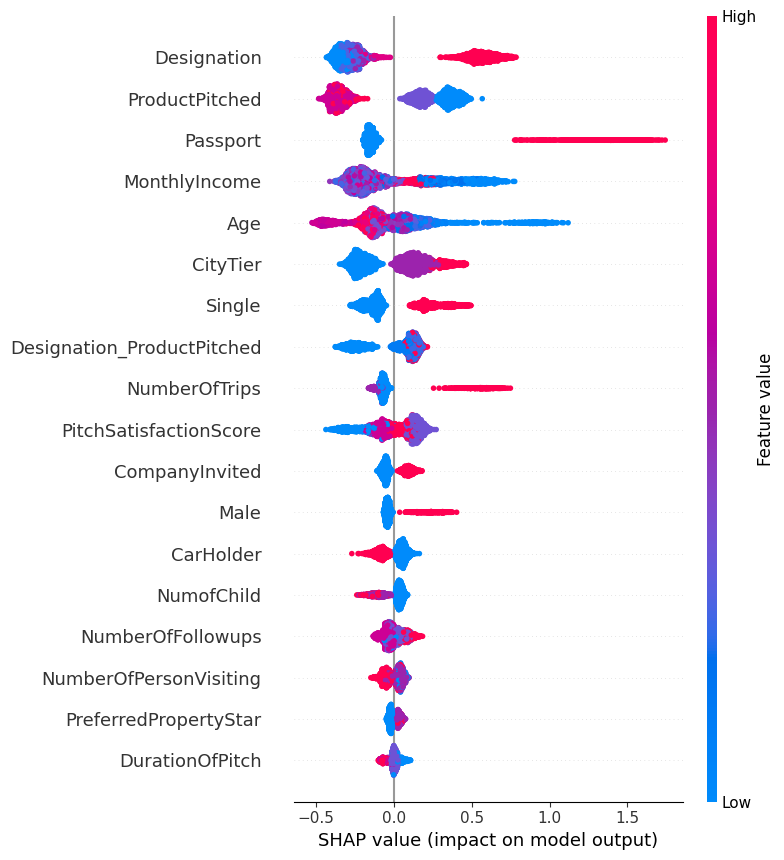

In [67]:
import shap
import lightgbm as lgb
import matplotlib.pyplot as plt
shap.initjs()
explainer = shap.TreeExplainer(model=models[0])
# 横軸：SHAP値 (0からの貢献度、右=プラスの影響)
# 縦軸：特徴量 (上にあるほど重要)
# 色：その特徴の値 (赤=大きい値、青=小さい値)
# ① SHAPのexplainerを作成
explainer = shap.TreeExplainer(models[0])
# ② SHAP値を計算（X_trainは学習に使った特徴量データ）
shap_values = explainer.shap_values(train.drop("ProdTaken",axis=1))
# ③ summary plotで全体の重要度と分布を見る
shap.summary_plot(shap_values, train.drop("ProdTaken",axis=1))

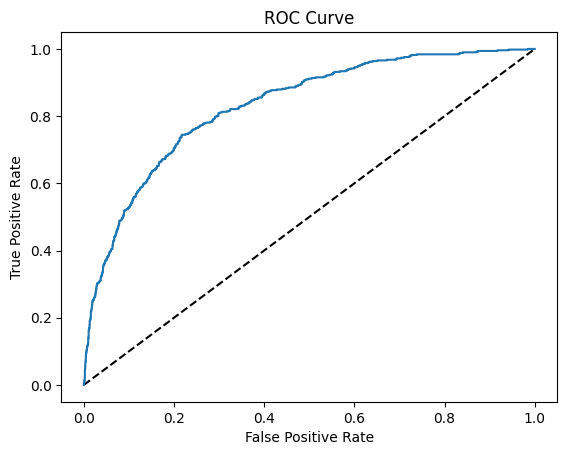

In [68]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(train[TARGET],oof_lgb)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr,label='LogisticRegression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

7. 提出

In [69]:
# submit_sample.csvを読み込みます。
submit = pd.read_csv("/content/sample_submit.csv", header=None)
submit.head(1)

,0,1
0,3489,0.119451


In [70]:
# テストデータを用いて予測します。
predict0 = models[0].predict(test)
predict1 = models[1].predict(test)
predict2 = models[2].predict(test)
predict = (predict0 + predict1 + predict2) / 3
submit[1] = predict

In [71]:
# 提出
submit.to_csv("submission.csv", index=False, header=None)